In [ ]:
install.packages("zoo")
library(zoo)  # For rollmean function
install.packages("corrplot")
library(corrplot)
library(dplyr)
install.packages("Synth")
library(Synth)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘nloptr’, ‘pracma’, ‘kernlab’, ‘optimx’, ‘rgenoud’


##
## Synth Package: Implements Synthetic Control Methods.


## See https://web.stanford.edu/~jhain/synthpage.html for additional information.





In [ ]:
# Set options to avoid scientific notation
options(scipen = 999)

In [ ]:
df <- read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRY5m_QO4kgmkSN-g4iH2wfDl-TAinhLQY8DKd4A2nJ16HhfnbCmB-wq61WlEgFQE8gwspH7BRHG5ZV/pub?gid=374297017&single=true&output=csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_balance_by_holdings_in_usd_X_1k____10k,mean_balance_by_holdings_in_usd_X_10k____100k,mean_balance_by_time_held_undefined_Traders___1M_,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.02262475,0.06516071,67019.43,28969.57,74398.71,82846.86,⋯,145375588,488349124,5388861669,3528.571,7147.143,0.4966644,2624.143,1686788,315903.9,1370885
2,ADA,2,2019-05-12,2019-05-15,0.03601421,0.08127786,66854.00,25861.86,70100.86,85052.71,⋯,162007475,586087651,5639494075,5915.714,11416.286,0.5089417,3852.000,1718791,316917.6,1401874
3,ADA,2,2019-05-19,2019-05-22,0.03053651,0.08158071,67735.00,25901.86,70068.00,85799.29,⋯,167948345,590167296,6011979991,5453.000,9778.571,0.5577316,3413.143,1760897,320248.1,1440649
4,ADA,2,2019-05-26,2019-05-29,0.03101587,0.08784929,68363.71,25180.86,68529.86,87859.29,⋯,177086679,626765220,5188468968,5460.429,10043.143,0.5444217,3696.429,1799145,323855.0,1475290
5,ADA,2,2019-06-02,2019-06-05,0.02991540,0.08593857,69135.86,25527.43,69042.29,88747.57,⋯,178208747,620632898,5055810888,5177.857,9778.429,0.5294496,3512.143,1837127,326977.0,1510150
6,ADA,2,2019-06-09,2019-06-12,0.02899247,0.08746786,69671.57,25379.29,68742.71,89283.86,⋯,183560163,628547917,5028709323,4867.286,9533.571,0.5142947,3111.571,1870222,328899.9,1541323


[1] "mean_active_addresses_ratio_Active"                
[2] "mean_new_adoption_rate_New_Adoption_Rate"          
[3] "mean_number_of_transactions_Number_Of_Transactions"
[4] "mean_average_time_between_transactions_Seconds"    
[5] "mean_total_addresses_Total"                        
[6] "mean_balance_by_time_held_undefined_Traders___1M_" 
[7] "cryptono"                                          
[8] "mean_addresses_by_holdings_in_usd_X_0_00____1_00"  
[9] "mean_addresses_by_holdings_in_usd_X_1_00____10_00" 


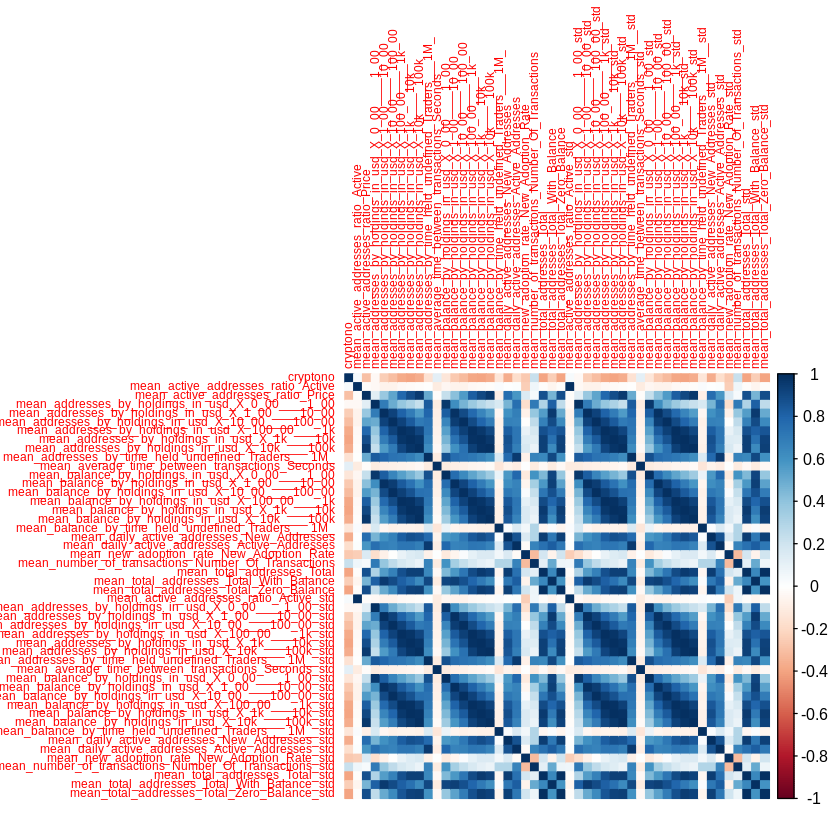

In [ ]:
# Calculate correlation matrix for all numeric predictors in the dataset
# Exclude non-numeric columns to get correlations only between numeric predictors
numeric_df <- df %>% select(where(is.numeric))
cor_matrix <- cor(numeric_df, use = "complete.obs")

# Visualize the correlation matrix to see how predictors correlate
corrplot(cor_matrix, method = "color", tl.cex = 0.6)


# Set the initial predictors list
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_"
)

# Define a threshold for low correlation (adjust as necessary)
cor_threshold <- 0.75

# Function to add predictors with low correlation to existing predictors_list
add_predictors <- function(cor_matrix, predictors_list, cor_threshold) {
  for (col in colnames(cor_matrix)) {
    if (col %in% predictors_list) next  # Skip if already in predictors_list

    # Calculate maximum absolute correlation of this column with predictors in predictors_list
    max_cor <- max(abs(cor_matrix[col, predictors_list]), na.rm = TRUE)

    # Add to predictors_list if maximum correlation is below threshold
    if (max_cor < cor_threshold) {
      predictors_list <- c(predictors_list, col)
    }
  }
  return(predictors_list)
}

# Apply the function to extend the predictors_list
predictors_list <- add_predictors(cor_matrix, predictors_list, cor_threshold)

# Check the extended predictors_list
print(predictors_list)

# Price normalized with a z-score

[1] "2022-05-29"

[1]  1 54 82

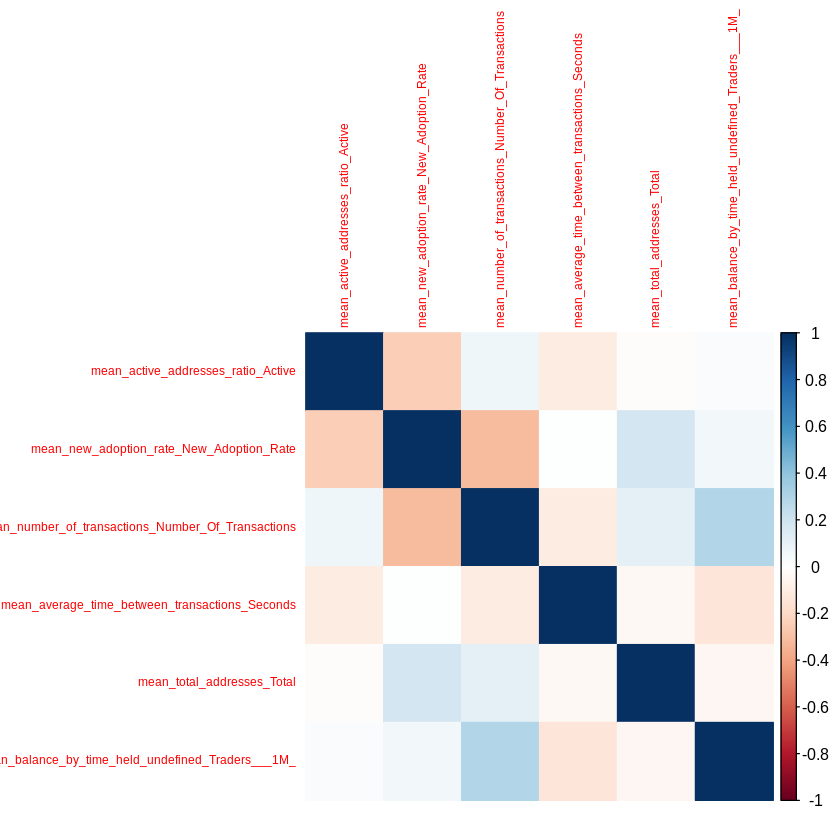

In [ ]:
# Converting variables to the right type for dataprep
df$cryptono <- as.numeric(df$cryptono) # required by dataprep()
df$week <- as.Date(df$week, format="%Y-%m-%d")

# Calculate z-score standardized price column
df <- df %>%
  mutate(price_norm = (mean_active_addresses_ratio_Price - mean(mean_active_addresses_ratio_Price, na.rm = TRUE)) /
           sd(mean_active_addresses_ratio_Price, na.rm = TRUE))

# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Create week index based on the earliest week
ref_date <- min(df$week) # Determine the reference date (the earliest week in the dataset)
df$week_index <- as.numeric(difftime(df$week, ref_date, units = "weeks")) + 1 # Create the week index
max(df$week)
# Convert key dates to indices
dates <- as.Date(c("2019-05-05", "2020-05-10", "2020-11-22")) # Define the target dates
week_indices <- sapply(dates, function(date) {
  as.numeric(difftime(date, ref_date, units = "weeks")) + 1
}) # Calculate the number of weeks between the reference date and each target date
week_indices # Display the results


#2019-05-05: 1
#2020-05-10: 54
#2020-11-22: 82 (half a year after treatment)


# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_"
)

# Create a correlation matrix
cor_matrix <- cor(df[predictors_list], use = "complete.obs")
# Visualize the correlation matrix
corrplot(cor_matrix, method = "color", tl.cex = 0.6)

# Identify outliers using boxplots
#for (pred in predictors_list) {
#  boxplot(df[[pred]], main = pred)
#}

In [ ]:

dataprep.out <-
  dataprep(df,
           predictors = predictors_list,
           predictors.op = "mean",
           dependent     = "mean_active_addresses_ratio_Price", # Use normalized price
           unit.variable = "cryptono",
           time.variable = "week_index",
           unit.names.variable   = "crypto",
           treatment.identifier  = 1,
           controls.identifier   = controls_identifier,
           time.predictors.prior = c(1:54),
           time.optimize.ssr     = c(1:54),
           time.plot             = c(1:100)
  )


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 74256240 

solution.v:
 3.05482e-05 2.17335e-05 0.001427651 1.97565e-05 0.9977096 0.0007907472 

solution.w:
 7e-10 6e-10 6e-10 1.3e-09 6e-10 1 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02        0.011
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01        0.283
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05   695598.016
mean_average_time_between_transactions_Seconds     5.896440e+02       14.241
mean_total_addresses_Total                         5.897094e+08 99109981.469
mean_balance_by_time_held_undefined_Traders___1M_  1.859831e+06 10690842.565
                                

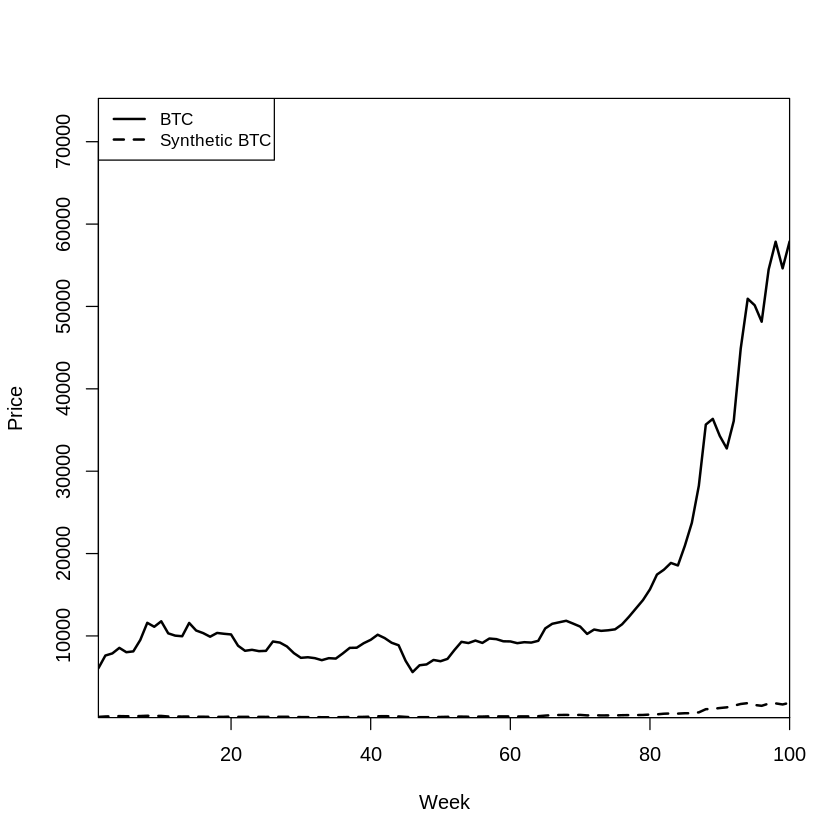

In [ ]:
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables
print(synth.tables   <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res    = synth.out)
)

# Plot: Main model
path.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Price"),
          Xlab         = c("Week"),
          Legend       = c("BTC","Synthetic BTC"),
          Legend.position = c("topleft")
)

# Smoothed price using simple smoothing

In [ ]:
# Define the window size for the moving average
window_size <- 5  # can adjust this value

# Calculate the smoothed price using a simple moving average
df <- df %>%
  group_by(cryptono) %>%  # Apply smoothing separately for each cryptocurrency
  arrange(week_index) %>%
  mutate(
    price_smooth = rollmean(mean_active_addresses_ratio_Price, k = window_size, fill = NA, align = "right")
  ) %>%
  ungroup()

# Remove rows with NA in price_smooth
df <- df %>%
  filter(!is.na(price_smooth))

In [ ]:
df$cryptono <- as.numeric(df$cryptono)

In [ ]:
# Define the time periods (adjusted if necessary due to NA removal)
time_predictors_prior <- c(1:(54 - window_size + 1))  # Adjusted for the window size
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:(100 - window_size + 1))  # Adjusted for the window size

 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


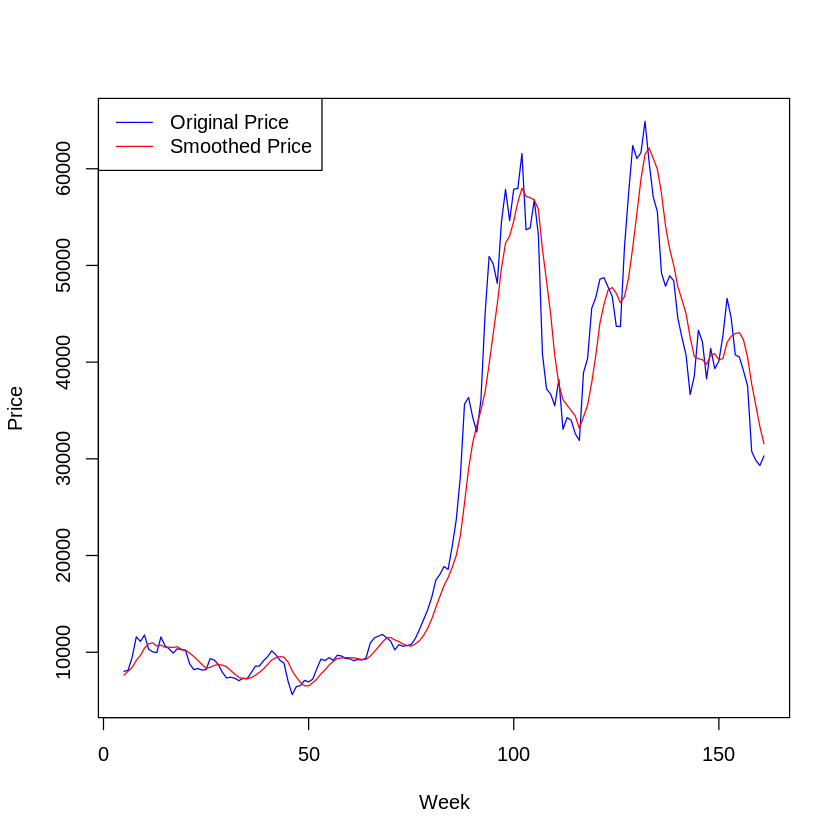

In [ ]:
# Plot original vs. smoothed price for BTC
btc_data <- df %>% filter(cryptono == 1)
plot(btc_data$week_index, btc_data$mean_active_addresses_ratio_Price, type = "l", col = "blue", ylim = range(btc_data$mean_active_addresses_ratio_Price, btc_data$price_smooth, na.rm = TRUE), ylab = "Price", xlab = "Week")
lines(btc_data$week_index, btc_data$price_smooth, col = "red")
legend("topleft", legend = c("Original Price", "Smoothed Price"), col = c("blue", "red"), lty = 1)


In [ ]:
head(df)
write.csv(df, "/content/sample_data/smoothed_df.csv", row.names = FALSE)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,price_norm,week_index,price_smooth
,<chr>,<dbl>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ADA,2,2019-06-02,2019-06-05,0.02991540,8.593857e-02,69135.8571,2.552743e+04,69042.2857,88747.571,⋯,5177.8571,9778.42857,0.5294496,3512.1429,1837127.00,326977.000,1.510150e+06,-0.2025576,5,8.036143e-02
2,ANKR,4,2019-06-02,2019-06-05,0.02047856,7.793357e-03,230.8571,9.957143e+01,273.5714,1474.429,⋯,23.0000,67.71429,0.3281680,158.4286,10779.00,3303.286,7.475714e+03,-0.2025689,5,7.514314e-03
3,BTC,1,2019-06-02,2019-06-04,0.03329573,8.025589e+03,7293255.0000,5.833338e+06,6153530.1430,3856229.571,⋯,394817.0000,820061.42860,0.4819174,335947.0000,529286529.70,24628305.140,5.046582e+08,0.9619236,5,7.631475e+03
4,CRO,5,2019-06-02,2019-06-05,0.09559875,6.943857e-02,979.2857,2.698714e+03,10367.2857,8583.143,⋯,301.7143,2395.00000,0.2132339,2437.5714,27075.43,25502.429,1.573000e+03,-0.2025600,5,6.839886e-02
5,DOGE,6,2019-06-02,2019-06-05,0.03199158,3.101143e-03,1947707.0000,3.693273e+05,228002.4286,82759.429,⋯,23870.4286,75375.00000,0.3232197,27569.2857,41093968.00,2359367.286,3.873460e+07,-0.2025696,5,2.975429e-03
6,ENJ,7,2019-06-02,2019-06-05,0.02161264,1.523500e-01,3243.4286,2.482714e+03,8697.8571,8946.429,⋯,175.8571,597.57143,0.2544707,1106.7143,97374.71,27633.714,6.974100e+04,-0.2025479,5,1.535857e-01


In [ ]:
df1 <- read.csv("/content/sample_data/smoothed_df.csv")

In [ ]:
df1 <- as.data.frame(df)
class(df1)

[1] "data.frame"

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(df1,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_smooth",
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,
  controls.identifier = controls_identifier,
  time.predictors.prior = c(5:54),
  time.optimize.ssr = c(5:54),
  time.plot = c(5:100)
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 74724894 

solution.v:
 3.77616e-05 6.0751e-06 0.001276116 1.30497e-05 0.997882 0.0007849711 

solution.w:
 7e-10 6e-10 6e-10 1.3e-09 6e-10 1 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.800000e-02 1.000000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.090000e-01 2.810000e-01
mean_number_of_transactions_Number_Of_Transactions 3.161100e+05 6.880061e+05
mean_average_time_between_transactions_Seconds     5.906700e+02 1.427100e+01
mean_total_addresses_Total                         5.951286e+08 1.003349e+08
mean_balance_by_time_held_undefined_Traders___1M_  1.851011e+06 1.071417e+07
                                  

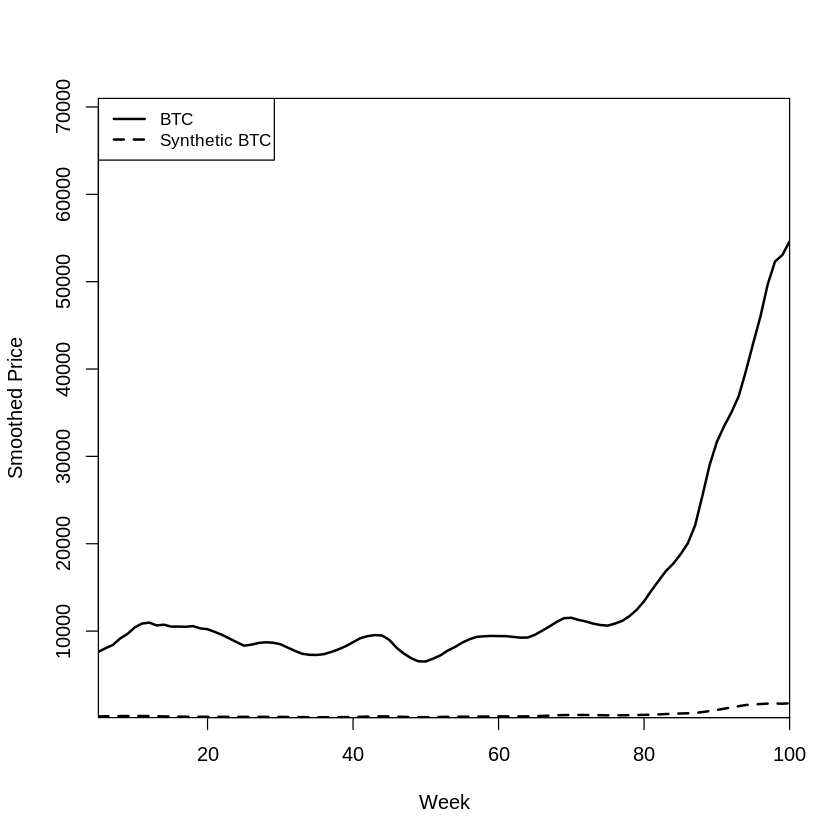

In [ ]:
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Price",
  Xlab = "Week",
  Legend = c("BTC", "Synthetic BTC"),
  Legend.position = "topleft"
)

# Exponential smoothing

In [ ]:
install.packages("TTR")
library(TTR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘xts’




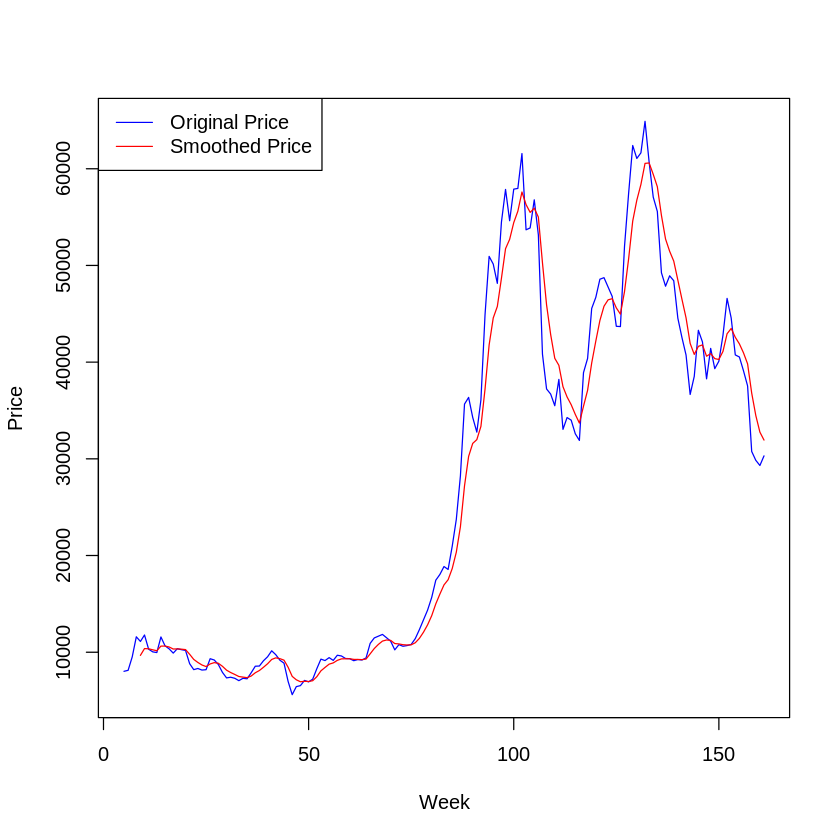

In [ ]:
# Using Exponential Moving Average
df <- df %>%
  group_by(cryptono) %>%
  arrange(week_index) %>%
  mutate(
    price_smooth = EMA(mean_active_addresses_ratio_Price, n = window_size)
  ) %>%
  ungroup()

# Plot original vs. smoothed price for BTC
btc_data <- df %>% filter(cryptono == 1)
plot(btc_data$week_index, btc_data$mean_active_addresses_ratio_Price, type = "l", col = "blue", ylim = range(btc_data$mean_active_addresses_ratio_Price, btc_data$price_smooth, na.rm = TRUE), ylab = "Price", xlab = "Week")
lines(btc_data$week_index, btc_data$price_smooth, col = "red")
legend("topleft", legend = c("Original Price", "Smoothed Price"), col = c("blue", "red"), lty = 1)

In [ ]:
write.csv(df, "/content/sample_data/smoothed_exp_df.csv", row.names = FALSE)

In [ ]:
df2 <- read.csv("/content/sample_data/smoothed_exp_df.csv")

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(df2,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_smooth",
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,
  controls.identifier = controls_identifier,
  time.predictors.prior = c(9:54),
  time.optimize.ssr = c(9:54),
  time.plot = c(9:100)
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 74824641 

solution.v:
 5.34704e-05 3.8322e-06 0.0008719074 7.896e-07 0.9982552 0.0008147638 

solution.w:
 7e-10 6e-10 6e-10 1.3e-09 6e-10 1 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 6e-10 6e-10 6e-10 6e-10 6e-10 6e-10 7e-10 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.800000e-02 1.000000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.110000e-01 2.810000e-01
mean_number_of_transactions_Number_Of_Transactions 3.130911e+05 6.750628e+05
mean_average_time_between_transactions_Seconds     5.915060e+02 1.430400e+01
mean_total_addresses_Total                         6.004726e+08 1.015070e+08
mean_balance_by_time_held_undefined_Traders___1M_  1.823065e+06 1.068004e+07
                                  

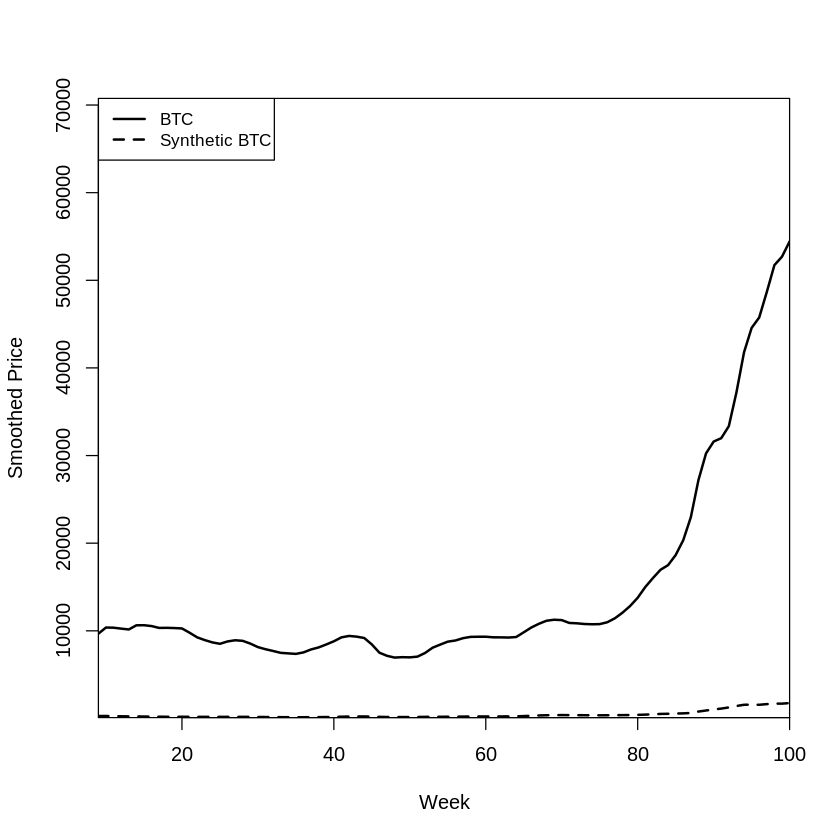

In [ ]:
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Price",
  Xlab = "Week",
  Legend = c("BTC", "Synthetic BTC"),
  Legend.position = "topleft"
)

In [ ]:
df <- read.csv("/content/sample_data/df_w_weekly_index")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_balance_by_time_held_undefined_Traders___1M_,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,price_norm,week_index
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,ADA,2,2019-05-05,2019-05-08,0.02262475,0.06516071,67019.43,28969.57,74398.71,82846.86,⋯,5388861669,3528.571,7147.143,0.4966644,2624.143,1686788,315903.9,1370885,-0.2025606,1
2,ADA,2,2019-05-12,2019-05-15,0.03601421,0.08127786,66854.00,25861.86,70100.86,85052.71,⋯,5639494075,5915.714,11416.286,0.5089417,3852.000,1718791,316917.6,1401874,-0.2025583,2
3,ADA,2,2019-05-19,2019-05-22,0.03053651,0.08158071,67735.00,25901.86,70068.00,85799.29,⋯,6011979991,5453.000,9778.571,0.5577316,3413.143,1760897,320248.1,1440649,-0.2025582,3
4,ADA,2,2019-05-26,2019-05-29,0.03101587,0.08784929,68363.71,25180.86,68529.86,87859.29,⋯,5188468968,5460.429,10043.143,0.5444217,3696.429,1799145,323855.0,1475290,-0.2025573,4
5,ADA,2,2019-06-02,2019-06-05,0.02991540,0.08593857,69135.86,25527.43,69042.29,88747.57,⋯,5055810888,5177.857,9778.429,0.5294496,3512.143,1837127,326977.0,1510150,-0.2025576,5
6,ADA,2,2019-06-09,2019-06-12,0.02899247,0.08746786,69671.57,25379.29,68742.71,89283.86,⋯,5028709323,4867.286,9533.571,0.5142947,3111.571,1870222,328899.9,1541323,-0.2025574,6


# Recaled price

In [ ]:
# Rescale `mean_active_addresses_ratio_Price` for each unit separately
df <- df %>%
  group_by(cryptono) %>%
  mutate(
    price_rescaled = (mean_active_addresses_ratio_Price - mean(mean_active_addresses_ratio_Price, na.rm = TRUE)) /
                     sd(mean_active_addresses_ratio_Price, na.rm = TRUE)
  ) %>%
  ungroup()

# Check the structure of the rescaled data
head(df)

write.csv(df, "/content/sample_data/rescaled_price.csv", row.names = FALSE)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value,price_rescaled
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,2624.1429,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517,-0.7916933
ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,168.2857,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517,-0.7105527
BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,351674.4286,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517,-1.0830253
CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,242.8571,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517,-0.6092627
DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,28229.7143,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517,-0.7140147
ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,812.7143,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517,-0.7350081


In [ ]:
df <- read.csv("/content/sample_data/rescaled_price.csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value,price_rescaled
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,2624.1429,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517,-0.7916933
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,168.2857,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517,-0.7105527
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,351674.4286,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517,-1.0830253
4,CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,242.8571,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517,-0.6092627
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,28229.7143,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517,-0.7140147
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,812.7143,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517,-0.7350081


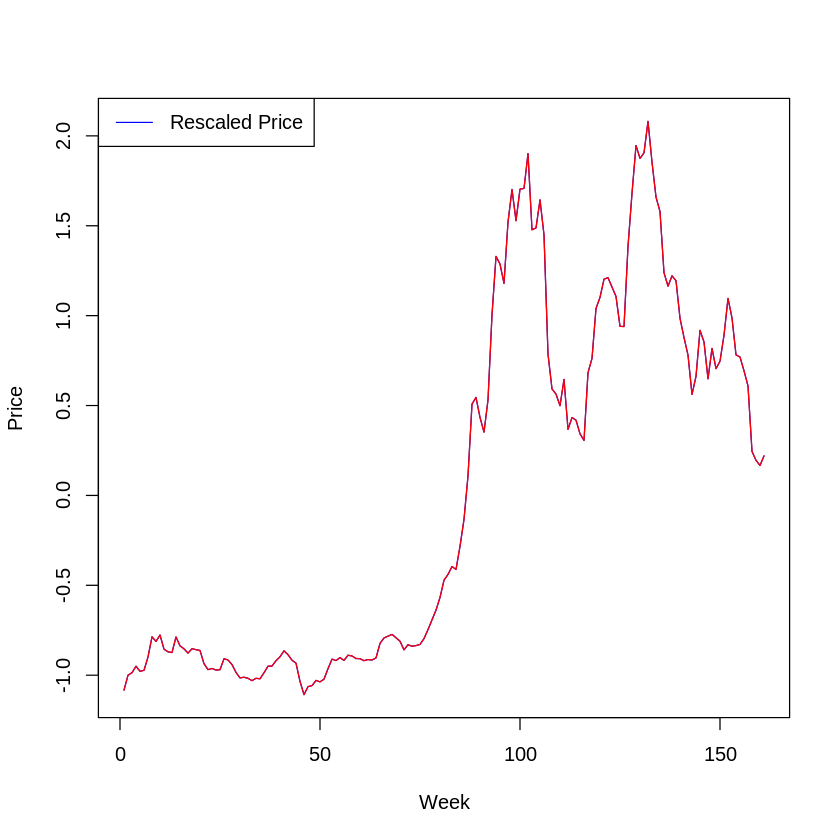

In [ ]:
# Plot rescaled price for BTC
btc_data <- df %>% filter(cryptono == 1)
plot(btc_data$week_index, btc_data$price_rescaled, type = "l", col = "blue", ylim = range(btc_data$price_rescaled, na.rm = TRUE), ylab = "Price", xlab = "Week")
lines(btc_data$week_index, btc_data$price_rescaled, col = "red")
legend("topleft", legend = "Rescaled Price", col = c("blue", "red"), lty = 1)

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:150)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_rescaled",  # Use the rescaled price
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.007732757 

solution.v:
 0.2612282 0.008025447 0.018631 0.02634232 0.3666782 0.1968162 0.1222786 

solution.w:
 7e-10 5e-10 5e-10 4.8e-09 5e-10 1 5e-10 5e-10 8e-10 2.9e-09 5e-10 5e-10 3e-10 5e-10 8e-10 5e-10 5e-10 9e-10 5e-10 6e-10 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02        0.011
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01        0.283
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05   695598.013
mean_average_time_between_transactions_Seconds     5.896440e+02       14.241
mean_total_addresses_Total                         5.897094e+08 99109981.168
mean_balance_by_time_held_undefined_Traders___1M_  1.859831e+06 10690908.775
mean_addresses_by_holdings

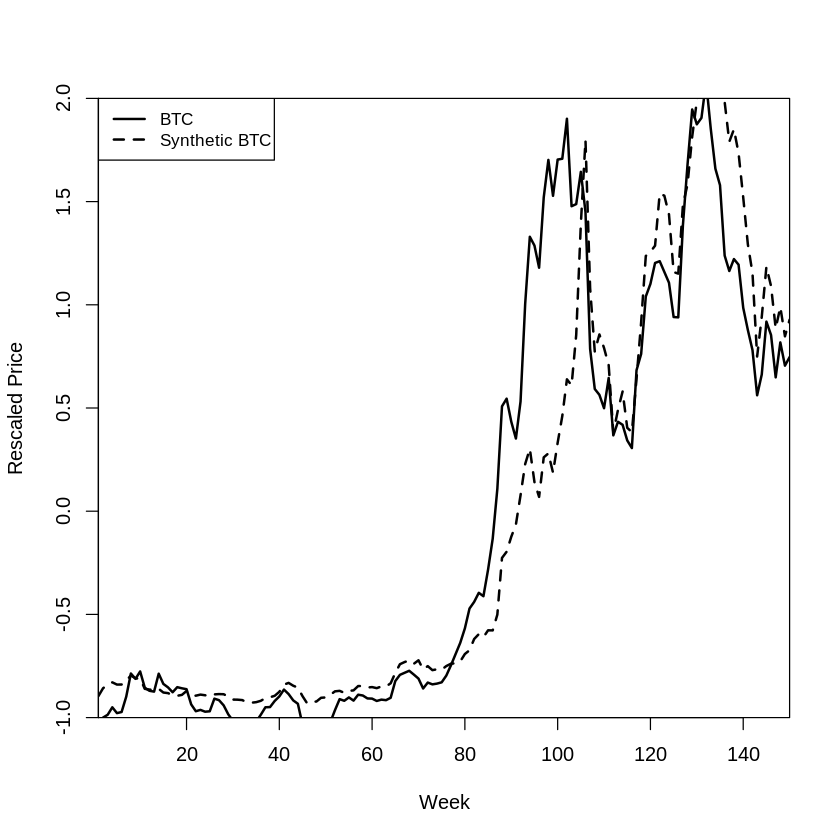

In [ ]:
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Rescaled Price",
  Xlab = "Week",
  Ylim = c(-1,2),
  Legend = c("BTC", "Synthetic BTC"),
  Legend.position = "topleft"
)

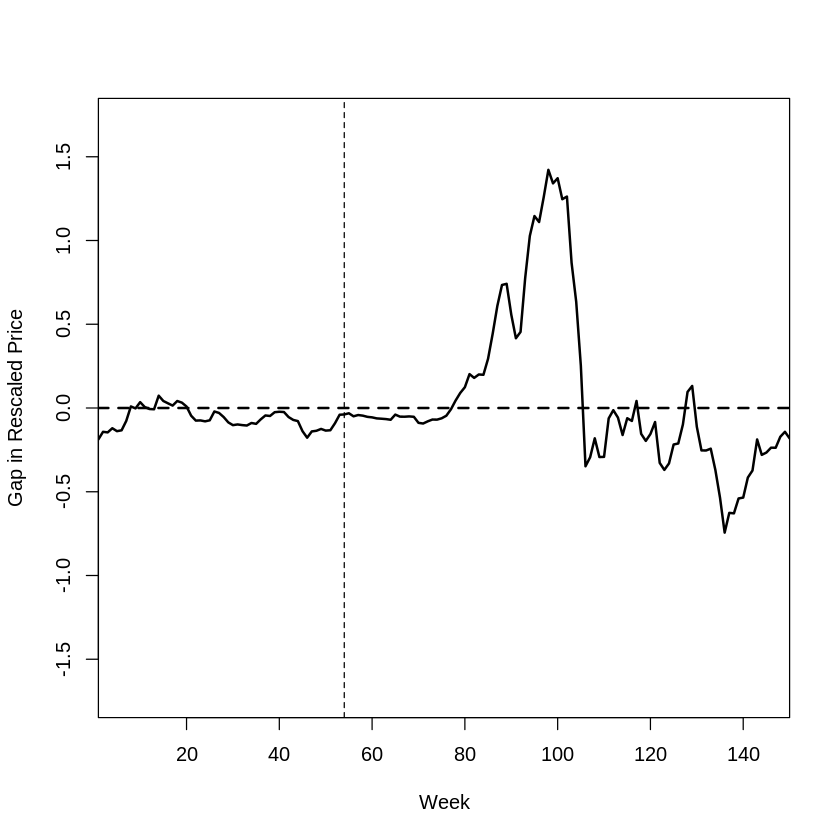

In [ ]:
# Gaps plot: shows difference between BTC and synthetic BTC over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Rescaled Price"),
  Xlab = c("Week"),
  Main = ""
)

# Add vertical line for intervention in gaps plot
abline(v = 54, lty = 2)

### Removing ETH, adding more predictors

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO + ETH
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Extended of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_daily_active_addresses_Active_Addresses",
  "mean_balance_by_holdings_in_usd_X_10_00____100_00",
  "mean_addresses_by_holdings_in_usd_X_10k____100k",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_rescaled",  # Use the rescaled price
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.005986667 

solution.v:
 0.09152259 0.2584495 0.0839622 9.2709e-06 0.0558498 0.2796504 0.01491601 5.50791e-05 0.2025069 0.01307826 

solution.w:
 0.3971474 4.7e-09 4.6e-09 0 5e-09 3.9e-09 4.5e-09 1.8e-09 9.6e-09 3.8e-09 0.6028524 1.48e-08 4.3e-09 5.5e-09 4.8e-09 1.7e-09 9.64e-08 5.3e-09 7.07e-08 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 2.300000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 4.650000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 2.678395e+03
mean_average_time_between_transactions_Seconds     5.896440e+02 6.002200e+01
mean_total_addresses_Total                         5.897094e+08 1.034852e+06
mean_balance_by_time_held_undefined_Tr

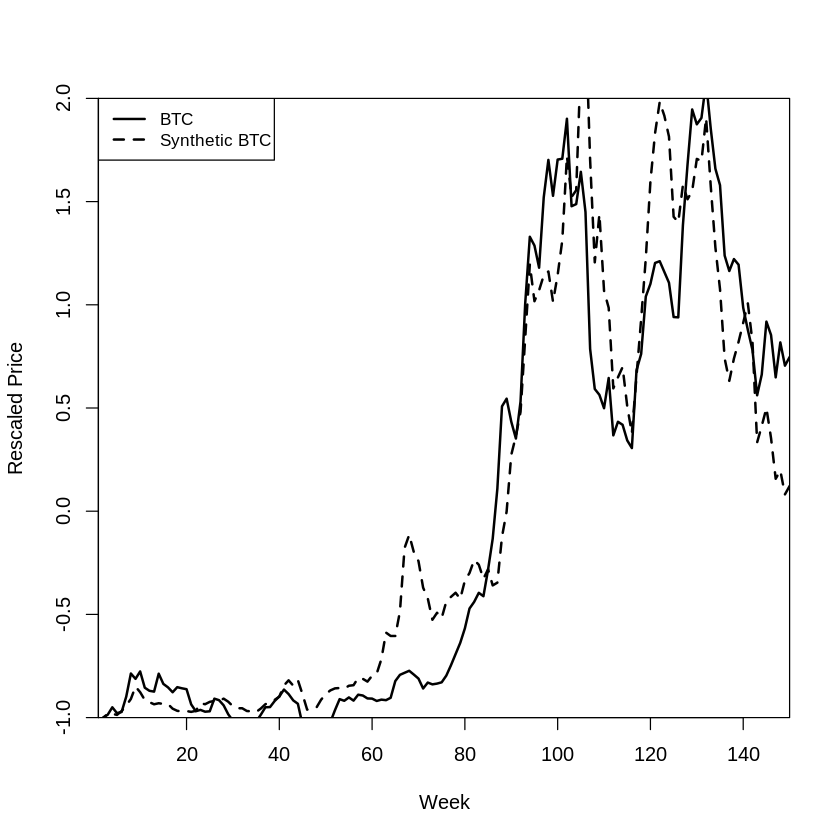

In [ ]:
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Rescaled Price",
  Xlab = "Week",
  Ylim = c(-1,2),
  Legend = c("BTC", "Synthetic BTC"),
  Legend.position = "topleft"
)

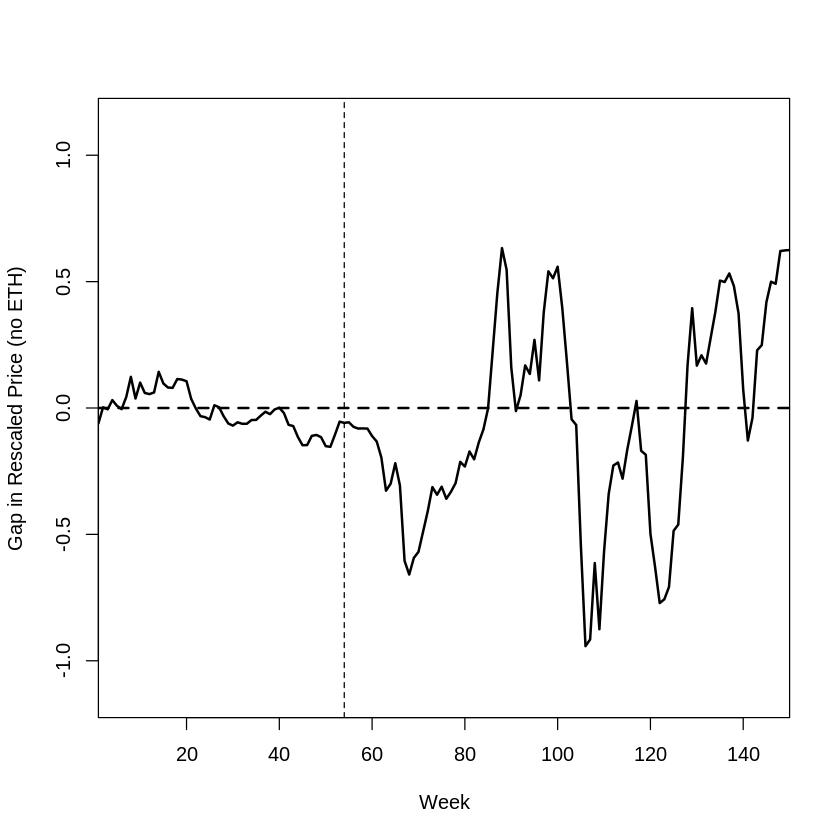

In [ ]:
# Gaps plot: shows difference between BTC and synthetic BTC over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Rescaled Price (no ETH)"),
  Xlab = c("Week"),
  Main = ""
)

# Add vertical line for intervention in gaps plot
abline(v = 54, lty = 2)

# Re-coding the DV as a wallet value

In [ ]:
df <- read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRY5m_QO4kgmkSN-g4iH2wfDl-TAinhLQY8DKd4A2nJ16HhfnbCmB-wq61WlEgFQE8gwspH7BRHG5ZV/pub?gid=374297017&single=true&output=csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_balance_by_holdings_in_usd_X_1k____10k,mean_balance_by_holdings_in_usd_X_10k____100k,mean_balance_by_time_held_undefined_Traders___1M_,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.02262475,0.06516071,67019.43,28969.57,74398.71,82846.86,⋯,145375588,488349124,5388861669,3528.571,7147.143,0.4966644,2624.143,1686788,315903.9,1370885
2,ADA,2,2019-05-12,2019-05-15,0.03601421,0.08127786,66854.00,25861.86,70100.86,85052.71,⋯,162007475,586087651,5639494075,5915.714,11416.286,0.5089417,3852.000,1718791,316917.6,1401874
3,ADA,2,2019-05-19,2019-05-22,0.03053651,0.08158071,67735.00,25901.86,70068.00,85799.29,⋯,167948345,590167296,6011979991,5453.000,9778.571,0.5577316,3413.143,1760897,320248.1,1440649
4,ADA,2,2019-05-26,2019-05-29,0.03101587,0.08784929,68363.71,25180.86,68529.86,87859.29,⋯,177086679,626765220,5188468968,5460.429,10043.143,0.5444217,3696.429,1799145,323855.0,1475290
5,ADA,2,2019-06-02,2019-06-05,0.02991540,0.08593857,69135.86,25527.43,69042.29,88747.57,⋯,178208747,620632898,5055810888,5177.857,9778.429,0.5294496,3512.143,1837127,326977.0,1510150
6,ADA,2,2019-06-09,2019-06-12,0.02899247,0.08746786,69671.57,25379.29,68742.71,89283.86,⋯,183560163,628547917,5028709323,4867.286,9533.571,0.5142947,3111.571,1870222,328899.9,1541323


In [ ]:
min(df$week)

[1] "2019-05-05"

In [ ]:
# Define the baseline week (minimum week in the dataset)
baseline_week <- "2019-05-05"

# Calculate initial holdings for each cryptocurrency based on the baseline week
df <- df %>%
  group_by(cryptono) %>%  # Group by each cryptocurrency
  arrange(week) %>%       # Ensure data is ordered by week within each group
  mutate(
    # Find the baseline price on the first week for each cryptocurrency
    baseline_price = first(mean_active_addresses_ratio_Price[week == baseline_week]),

    # Calculate the initial quantity bought with $100
    initial_quantity = 100 / baseline_price,

    # Calculate wallet value over time
    wallet_value = initial_quantity * mean_active_addresses_ratio_Price
  ) %>%
  ungroup()

# Check the new `wallet_value` column (this is now the dependent variable)
head(df,20)

# Converting variables to the right type for dataprep
df$cryptono <- as.numeric(df$cryptono) # required by dataprep()
df$week <- as.Date(df$week, format="%Y-%m-%d")

# Create week index based on the earliest week
ref_date <- min(df$week) # Determine the reference date (the earliest week in the dataset)
df$week_index <- as.numeric(difftime(df$week, ref_date, units = "weeks")) + 1 # Create the week index
max(df$week)
# Convert key dates to indices
dates <- as.Date(c("2019-05-05", "2020-05-10", "2020-11-22")) # Define the target dates
week_indices <- sapply(dates, function(date) {
  as.numeric(difftime(date, ref_date, units = "weeks")) + 1
}) # Calculate the number of weeks between the reference date and each target date
week_indices # Display the results

write.csv(df, "/content/sample_data/recoded_price.csv", row.names = FALSE)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_daily_active_addresses_New_Addresses,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2,2019-05-05,2019-05-08,0.0226247483,6.516071e-02,6.701943e+04,2.896957e+04,7.439871e+04,8.284686e+04,⋯,3.528571e+03,7147.14286,0.49666443,2624.14286,1.686788e+06,3.159039e+05,1.370885e+06,6.516071e-02,1.534667e+03,100
ANKR,4,2019-05-05,2019-05-08,0.0227206396,7.666929e-03,2.254286e+02,1.044286e+02,2.508571e+02,1.478143e+03,⋯,2.542857e+01,74.57143,0.32048357,168.28571,1.018843e+04,3.281429e+03,6.907000e+03,7.666929e-03,1.304303e+04,100
BTC,1,2019-05-05,2019-05-07,0.0333215500,6.078957e+03,7.598899e+06,5.603131e+06,5.992359e+06,3.534754e+06,⋯,4.142689e+05,796877.42860,0.52001900,351674.42860,5.174124e+08,2.391125e+07,4.935011e+08,6.078957e+03,1.645019e-02,100
CRO,5,2019-05-05,2019-05-08,0.0088131426,6.951500e-02,8.378571e+02,2.526429e+03,1.139857e+04,6.907143e+03,⋯,1.214286e+01,208.28571,0.06726671,242.85714,2.494014e+04,2.363414e+04,1.306000e+03,6.951500e-02,1.438538e+03,100
DOGE,6,2019-05-05,2019-05-08,0.0335637685,2.578643e-03,1.929432e+06,3.606143e+05,2.217004e+05,7.377857e+04,⋯,2.193829e+04,77607.71429,0.29178829,28229.71429,4.033893e+07,2.314227e+06,3.802470e+07,2.578643e-03,3.878009e+04,100
ENJ,7,2019-05-05,2019-05-08,0.0186519921,1.411429e-01,2.981143e+03,2.364000e+03,8.503000e+03,8.486857e+03,⋯,1.047143e+02,493.14286,0.21136729,812.71429,9.306800e+04,2.643700e+04,6.663100e+04,1.411429e-01,7.085020e+02,100
ETH,8,2019-05-05,2019-05-08,0.0124616063,1.727221e+02,1.639836e+07,4.422126e+06,2.131426e+06,8.443456e+05,⋯,8.413929e+04,287288.85710,0.29249029,684938.28570,8.272875e+07,2.304932e+07,5.967943e+07,1.727221e+02,5.789646e-01,100
FTM,10,2019-05-05,2019-05-08,0.0194086086,8.746929e-03,4.984286e+02,1.381429e+02,1.032714e+03,2.817000e+03,⋯,2.542857e+01,110.28571,0.23010071,190.42857,1.437700e+04,5.681286e+03,8.695714e+03,8.746929e-03,1.143258e+04,100
GNO,11,2019-05-05,2019-05-08,0.0037481653,1.651071e+01,2.706143e+03,3.172429e+03,2.924714e+03,1.105143e+03,⋯,6.285714e+00,37.00000,0.18140614,45.85714,4.203414e+04,9.873429e+03,3.216071e+04,1.651071e+01,6.056673e+00,100


[1] "2022-05-29"

[1]  1 54 82

In [ ]:
df <- read.csv("/content/sample_data/recoded_price.csv")

In [ ]:
df <- read.csv("/content/sample_data/2020_recoded_smoothed (1).csv")

In [ ]:
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,7147.14286,0.49666443,2624.1429,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,74.57143,0.32048357,168.2857,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,796877.42860,0.52001900,351674.4286,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1
4,CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,208.28571,0.06726671,242.8571,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,77607.71429,0.29178829,28229.7143,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,493.14286,0.21136729,812.7143,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1


In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:95)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 765.5334 

solution.v:
 0.1778311 0.01266031 0.1632506 0.3474832 0.05726018 0.2415146 

solution.w:
 9.05612e-05 4.4423e-06 4.6614e-06 0.007542213 5.284e-06 0.7918867 9.2559e-06 0 1.74011e-05 2.96961e-05 2.675e-07 1.72678e-05 3.8292e-06 6.6382e-06 3.4253e-05 7.6238e-06 9.5237e-06 0.2003261 4.2307e-06 6e-10 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 2.400000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 2.970000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 5.511061e+05
mean_average_time_between_transactions_Seconds     5.896440e+02 5.431210e+02
mean_total_addresses_Total                         5.897094e+08 7.882442e+07
mean_balance_by_time_held_und

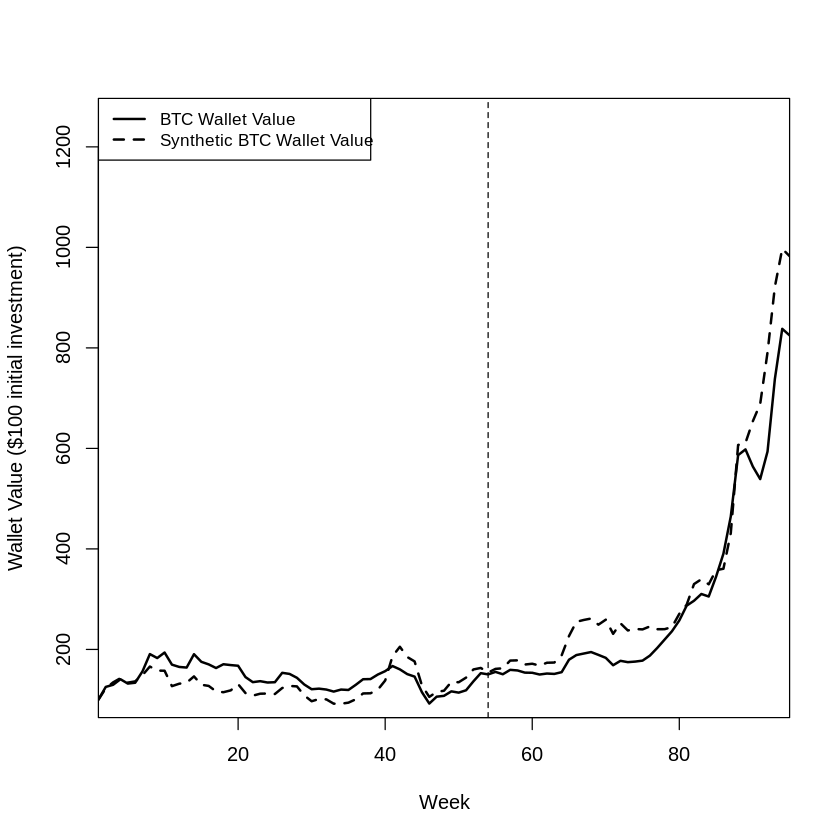

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

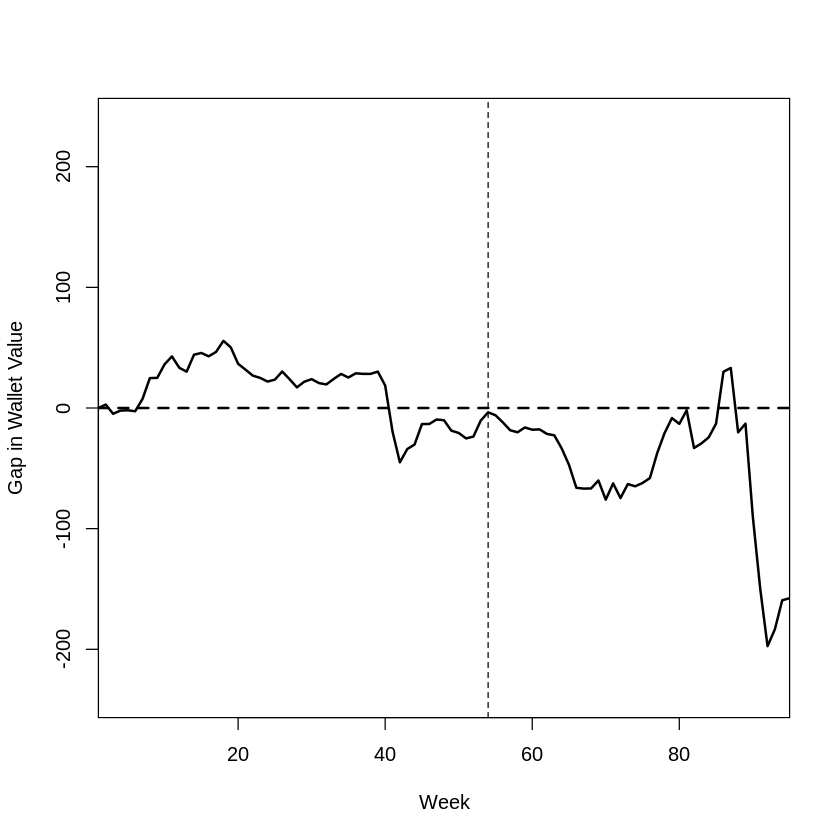

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 54,
       lty = 2)

### Adding predictors

In [ ]:
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 682.8309 

solution.v:
 0.2545306 0.03495245 0.1935985 0.1716642 0.1688434 0.09971744 0.07488244 0.001811039 

solution.w:
 5.0787e-06 3.77e-07 6.067e-07 0.1455866 9.528e-07 0.6237326 2.2579e-06 1.6e-09 1.284e-07 5.84e-08 4.674e-07 0.02992672 8.702e-07 1.4524e-06 1.9155e-06 1.5916e-06 3.2074e-06 0.2007346 5.641e-07 2.57e-08 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 2.600000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 3.190000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 4.384359e+05
mean_average_time_between_transactions_Seconds     5.896440e+02 5.522770e+02
mean_total_addresses_Total                         5.897094e+08 6.833498e+07
mean_balanc

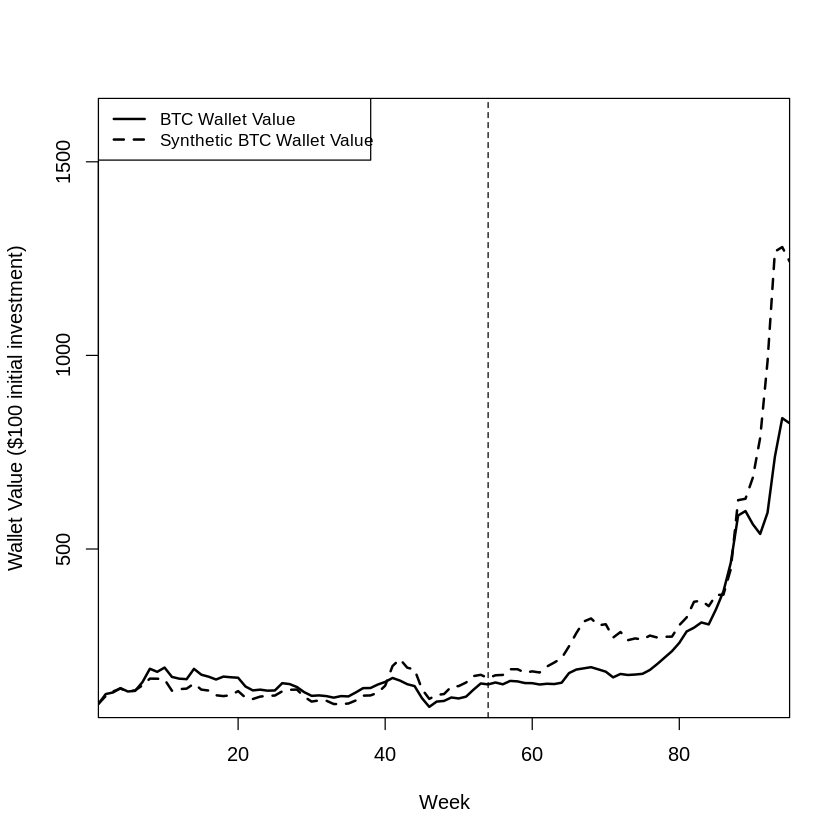

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

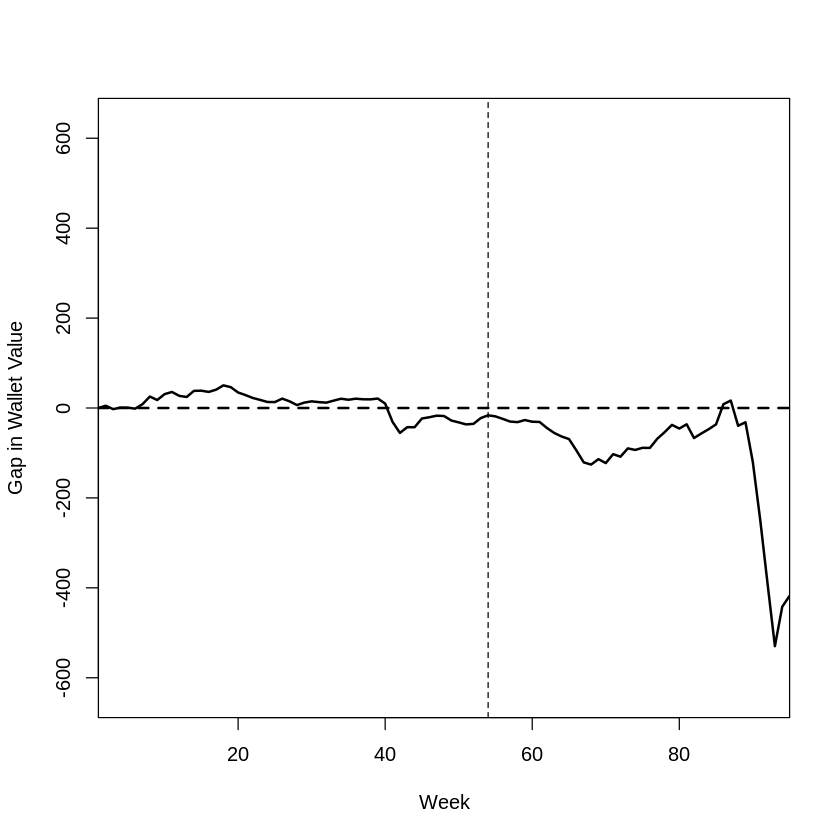

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 54,
       lty = 2)

### Removing ETH, DOGE

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8, 6) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 587.6989 

solution.v:
 0.03592062 0.1199837 0.2597488 0.0502438 0.01307117 0.2742645 0.1579327 0.08883457 

solution.w:
 0.155823 4.6e-09 3.7e-09 2.4e-09 1.25e-08 1.7e-08 2.9e-09 4.3e-09 4.1e-08 0.2300825 0.4998573 3.5e-09 3.98e-08 2.6e-09 3.6e-09 2.109e-07 3.6e-09 0.1142369 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 1.600000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 2.830000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 2.609474e+05
mean_average_time_between_transactions_Seconds     5.896440e+02 4.526430e+02
mean_total_addresses_Total                         5.897094e+08 2.179610e+06
mean_balance_by_time_held_undefined_Traders___1M_  1.859831e

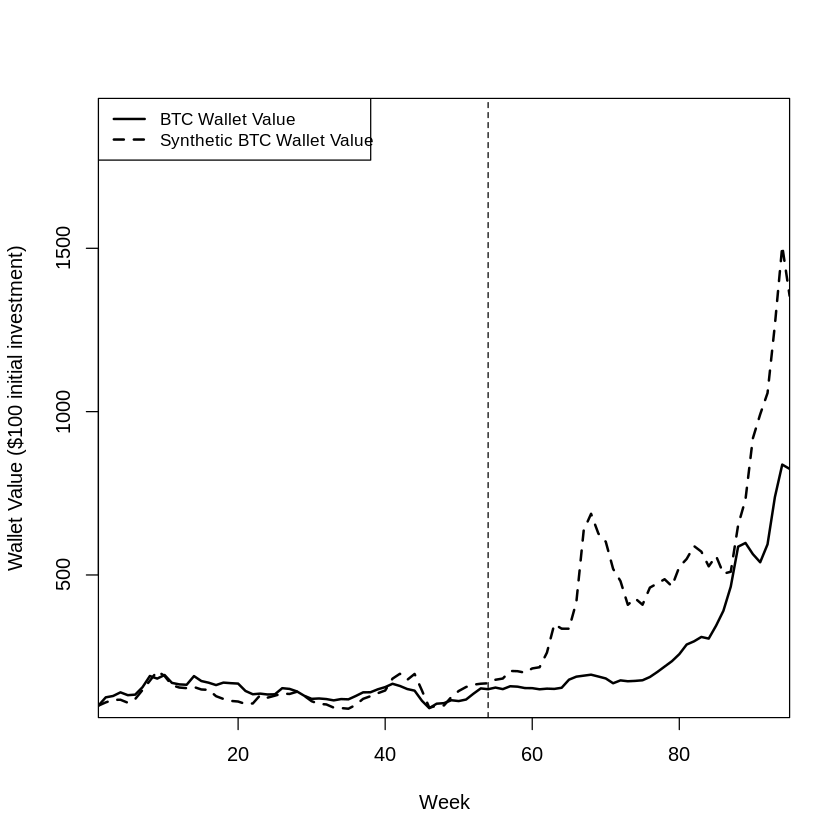

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

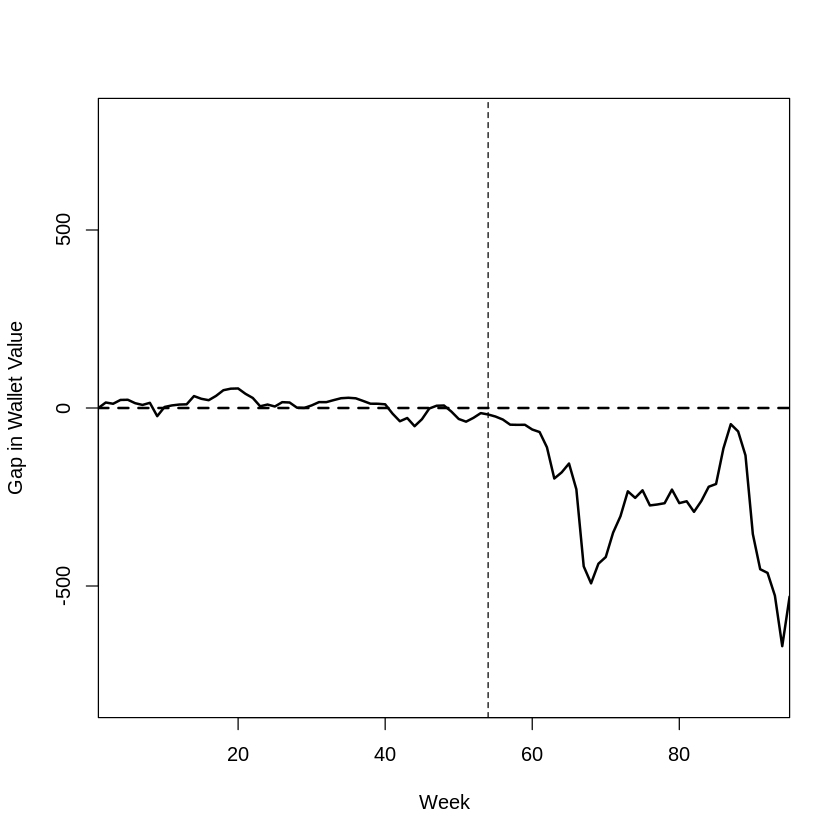

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 54,
       lty = 2)

# Re-coding the DV as a wallet value + taking the log of it

In [ ]:
# Load the data
df <- read.csv("/content/sample_data/recoded_price.csv")

# Add the log of wallet_value
df <- df %>%
  mutate(log_wallet_value = log(wallet_value))

# Save the modified dataframe to a new CSV file
write.csv(df, "/content/sample_data/recoded_price_with_log.csv", row.names = FALSE)

# Check the structure of the modified data (optional)
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,0.49666443,2624.1429,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,0.32048357,168.2857,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,0.52001900,351674.4286,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517
4,CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,0.06726671,242.8571,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,0.29178829,28229.7143,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,0.21136729,812.7143,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517


In [ ]:
df <- read.csv("/content/sample_data/recoded_price_with_log.csv")

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:120)

In [ ]:
summary(df$log_wallet_value)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.870   4.642   5.658   5.910   7.073  11.160 

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "log_wallet_value",  # Use the wallet log value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.04151268 

solution.v:
 0.1909245 0.009603086 0.07979002 0.4277547 0.02541802 0.2665093 3.759e-07 

solution.w:
 0.0002337449 7.69e-08 8.95e-08 0.005370153 1.596e-07 0.7787953 2.187e-07 0 3.562e-07 0.0002023138 0 3.8969e-06 4.85e-08 1.973e-07 1.43302e-05 3.495e-07 3.509e-07 0.2153783 9.89e-08 1.9e-09 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 2.500000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 2.980000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 5.419370e+05
mean_average_time_between_transactions_Seconds     5.896440e+02 5.827320e+02
mean_total_addresses_Total                         5.897094e+08 7.743038e+07
mean_balance_by_time_held_undefin

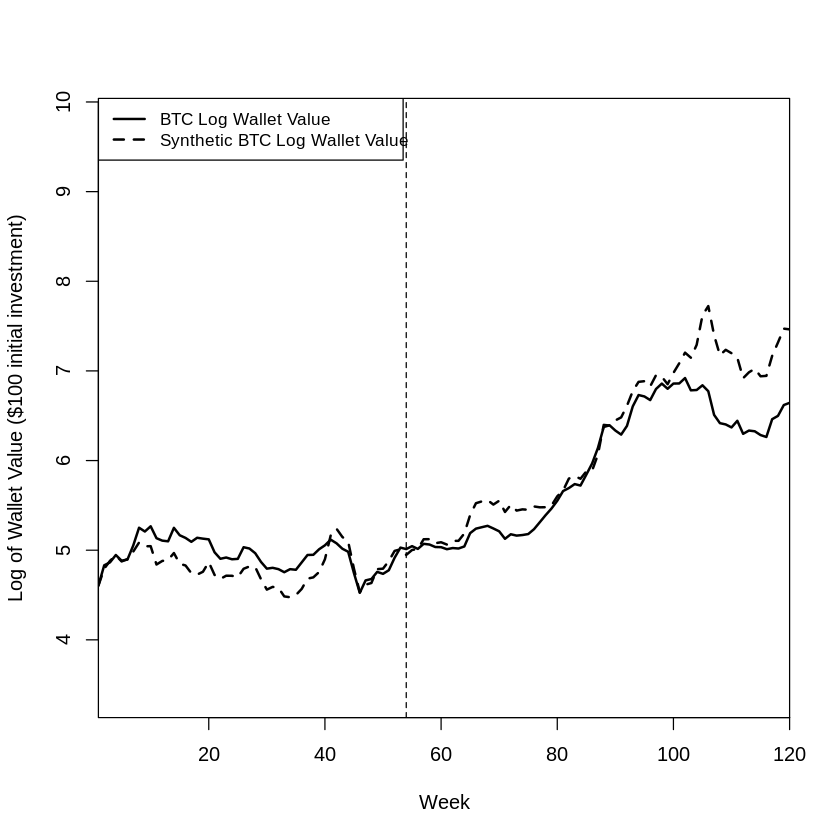

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results: Path plot
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Log of Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Log Wallet Value", "Synthetic BTC Log Wallet Value"),
  Legend.position = "topleft"
)

# Add vertical line for intervention
abline(v = 54, lty = 2)

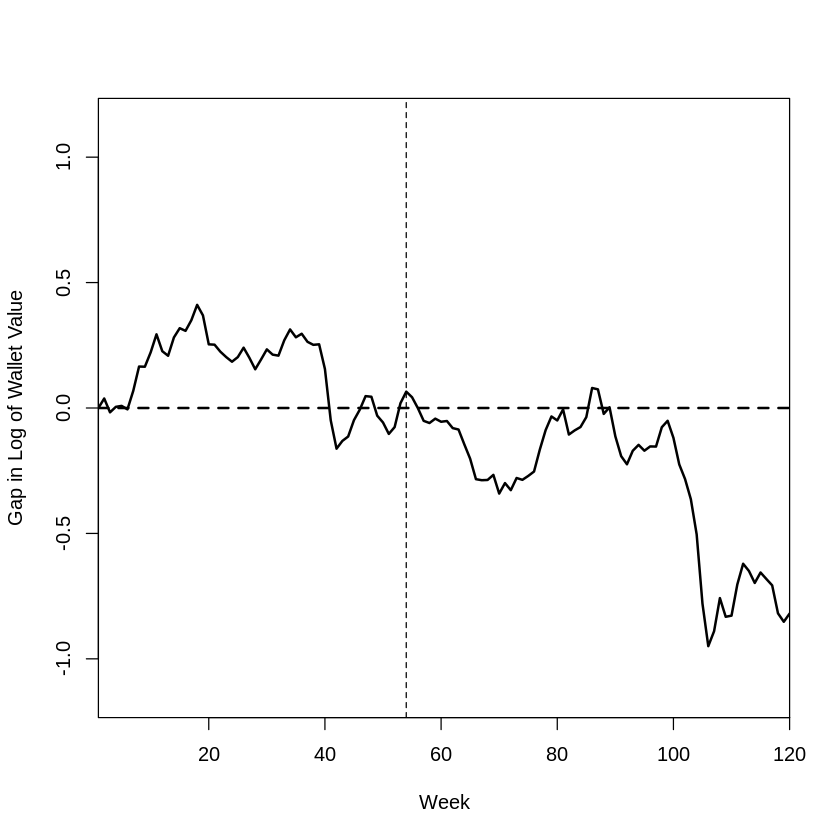

In [ ]:
# Gaps plot: shows difference between BTC and synthetic BTC over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Log of Wallet Value"),
  Xlab = c("Week"),
  Main = ""
)

# Add vertical line for intervention in gaps plot
abline(v = 54, lty = 2)

# Rescaled + Smoothed Price

In [ ]:
# Load the rescaled data
df <- read.csv("/content/sample_data/rescaled_price.csv")

# Define the window size for smoothing
window_size <- 5  # Adjust as needed

# Smooth the data, retaining the first 4 weeks
df <- df %>%
  group_by(cryptono) %>%  # Apply smoothing within each cryptocurrency
  arrange(week_index) %>%
  mutate(
    # For the first 4 weeks, use a simple moving average
    price_rescaled_smooth = ifelse(row_number() <= window_size,
                                   mean(price_rescaled[1:window_size], na.rm = TRUE),
                                   rollmean(price_rescaled, k = window_size, fill = NA, align = "right"))
  ) %>%
  ungroup()

# Save the modified dataframe with smoothed price to a new CSV file
write.csv(df, "/content/sample_data/smoothed_rescaled_price.csv", row.names = FALSE)
head(df)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value,price_rescaled,price_rescaled_smooth
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517,-0.7916933,-0.7712175
ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517,-0.7105527,-0.7137056
BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517,-1.0830253,-0.9995234
CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517,-0.6092627,-0.6166010
DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517,-0.7140147,-0.7106066
ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517,-0.7350081,-0.7219820


In [ ]:
df <- read.csv("/content/sample_data/smoothed_rescaled_price.csv")

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(5:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(5:110)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_rescaled_smooth",  # Use the smoothed rescaled price as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.006297656 

solution.v:
 0.1596358 0.01936999 0.1416898 0.1483585 0.1778067 0.1280225 0.2251167 

solution.w:
 1.3e-09 1.3e-09 9e-10 7.8e-09 7e-10 1 1.5e-09 8.4e-09 9e-10 2.9e-09 6.2e-09 9e-10 8e-10 9e-10 1.8e-09 8e-10 1e-09 9.6e-09 9e-10 0 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.800000e-02 1.000000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.090000e-01 2.810000e-01
mean_number_of_transactions_Number_Of_Transactions 3.161100e+05 6.880061e+05
mean_average_time_between_transactions_Seconds     5.906700e+02 1.427200e+01
mean_total_addresses_Total                         5.951286e+08 1.003348e+08
mean_balance_by_time_held_undefined_Traders___1M_  1.851011e+06 1.071429e+07
mean_addresses_by

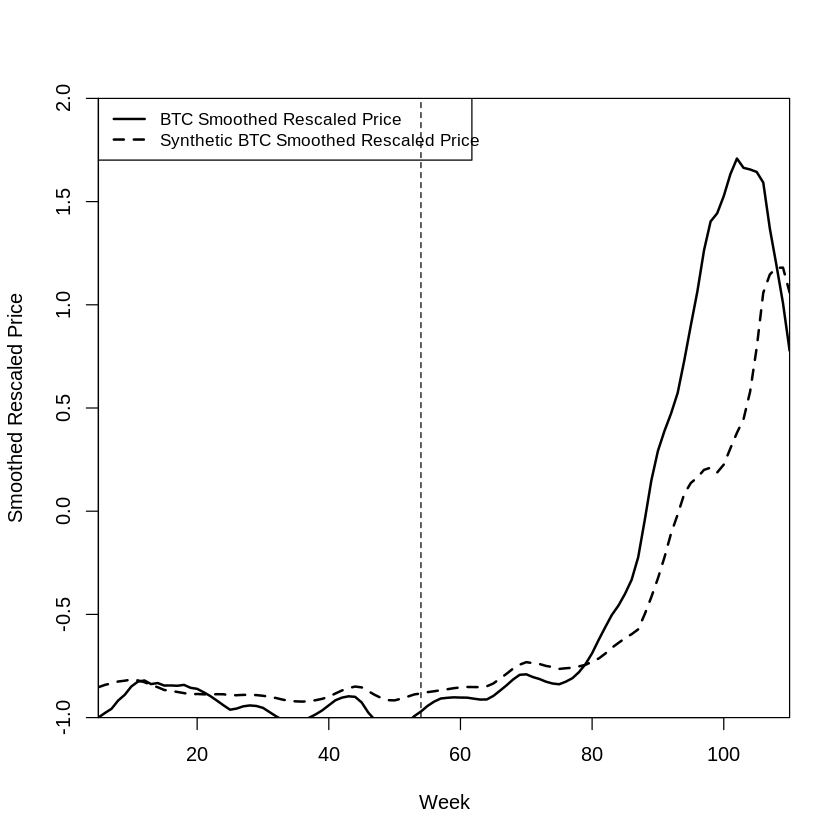

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Rescaled Price",
  Xlab = "Week",
  Ylim = c(-1, 2),
  Legend = c("BTC Smoothed Rescaled Price", "Synthetic BTC Smoothed Rescaled Price"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

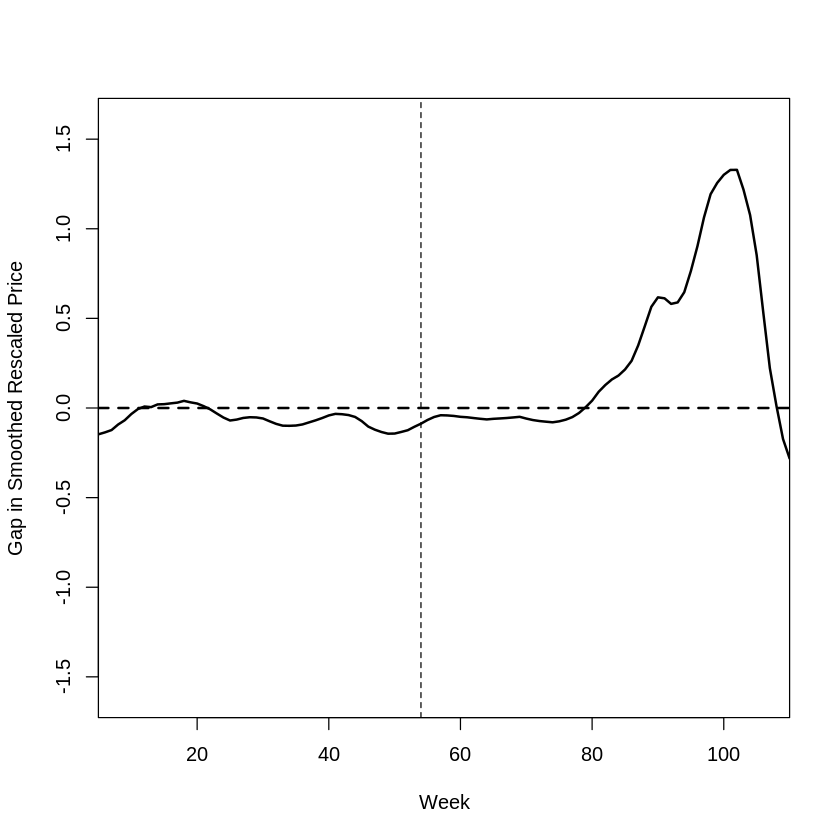

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Smoothed Rescaled Price"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

## Adding predictors, removing ETH & DOGE


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.002268903 

solution.v:
 0.1023207 0.06995125 0.2451588 0.01534854 0.1241636 0.4097322 0.001577078 0.0317478 

solution.w:
 9.64175e-05 4.6e-09 3.9e-09 2e-09 5.9e-09 4.2e-09 3.42e-08 2.4e-09 6e-09 0.734168 0.1972156 2.3e-09 5.24e-08 1.6e-09 1e-10 3.15e-08 2e-09 0.06851982 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 2.300000e-02
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 3.470000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 1.579717e+05
mean_average_time_between_transactions_Seconds     5.896440e+02 2.159590e+02
mean_total_addresses_Total                         5.897094e+08 9.292532e+05
mean_balance_by_time_held_undefined_Traders___1M_  1.859831e+0

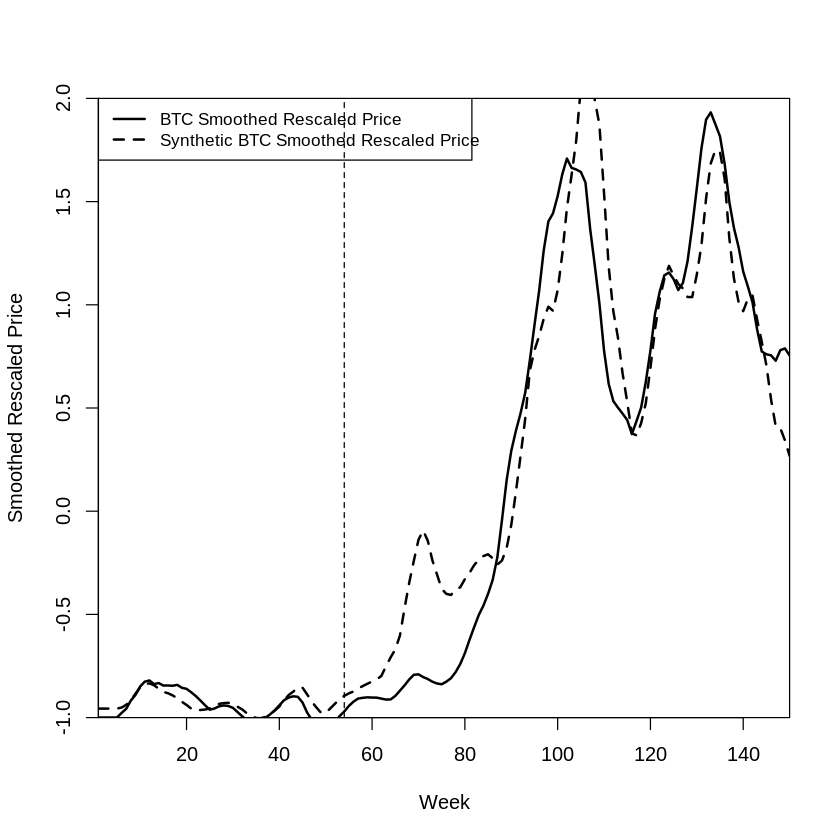

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8, 6) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units


# Extended list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:150)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "price_rescaled_smooth",  # Use the smoothed rescaled price as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Rescaled Price",
  Xlab = "Week",
  Ylim = c(-1, 2),
  Legend = c("BTC Smoothed Rescaled Price", "Synthetic BTC Smoothed Rescaled Price"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

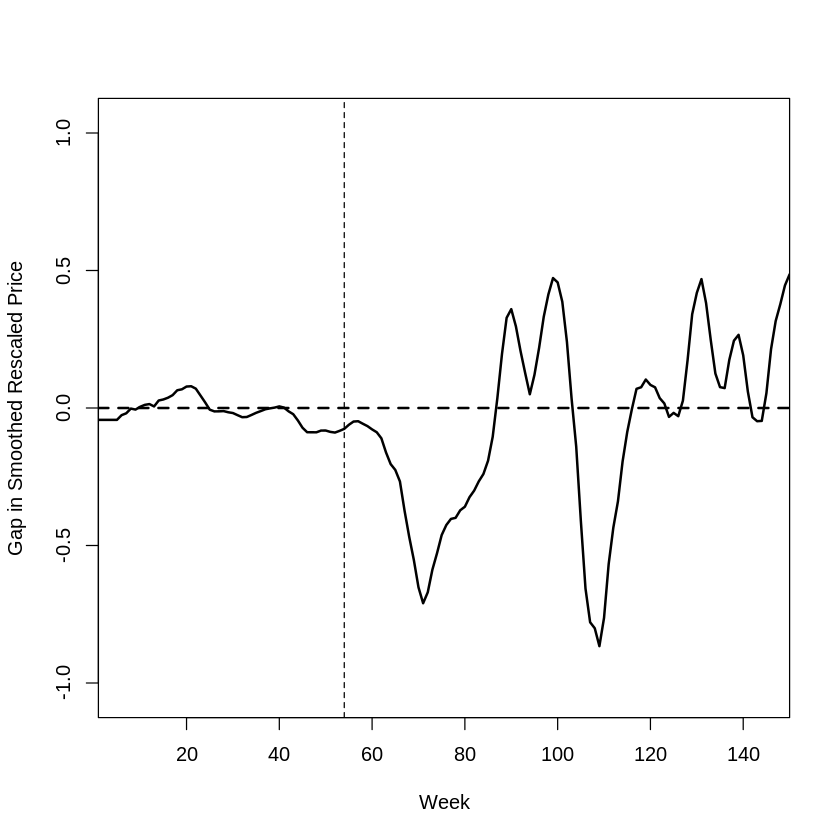

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Smoothed Rescaled Price"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

# Re-coded as Wallet Value + Smoothed Price

In [ ]:
df <- read.csv("/content/sample_data/recoded_price.csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_daily_active_addresses_Active_Addresses,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,0.065160714,67019.4286,28969.5714,74398.7143,82846.857,⋯,7147.14286,0.49666443,2624.1429,1686788.43,315903.857,1370885,0.065160714,1534.66703196,100,1
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,0.007666929,225.4286,104.4286,250.8571,1478.143,⋯,74.57143,0.32048357,168.2857,10188.43,3281.429,6907,0.007666929,13043.03269216,100,1
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6078.957143000,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,796877.42860,0.52001900,351674.4286,517412351.10,23911250.430,493501101,6078.957143000,0.01645019,100,1
4,CRO,5,2019-05-05,2019-05-08,0.008813143,0.069515000,837.8571,2526.4286,11398.5714,6907.143,⋯,208.28571,0.06726671,242.8571,24940.14,23634.143,1306,0.069515000,1438.53844494,100,1
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,0.002578643,1929431.5710,360614.2857,221700.4286,73778.571,⋯,77607.71429,0.29178829,28229.7143,40338928.29,2314227.429,38024701,0.002578643,38780.08919635,100,1
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,0.141142857,2981.1429,2364.0000,8503.0000,8486.857,⋯,493.14286,0.21136729,812.7143,93068.00,26437.000,66631,0.141142857,708.50202451,100,1


In [ ]:
# Define the window size for initial simple moving average and for EMA
window_size <- 4  # Number of periods for initial simple average and EMA

# Smooth the data
df <- df %>%
  group_by(cryptono) %>%
  arrange(week_index) %>%
  mutate(
    # For the first 4 weeks, use a simple moving average
    initial_smooth = ifelse(row_number() <= window_size,
                            mean(wallet_value[1:window_size], na.rm = TRUE),
                            NA_real_),

    # For the remaining weeks, apply EMA with window size of 4
    wallet_value_smoothed = ifelse(row_number() > window_size,
                                   EMA(wallet_value, n = window_size),
                                   initial_smooth)
  ) %>%
  ungroup()

# Check the structure of the smoothed data (optional)
head(df)

# Save the smoothed data to a new CSV file
write.csv(df, "/content/sample_data/recoded_and_smoothed_wallet_value.csv", row.names = FALSE)

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `wallet_value_smoothed = ifelse(...)`.
[36mℹ[39m In group 1: `cryptono = 1`.
[1mCaused by error in `EMA()`:[22m
[33m![39m could not find function "EMA"


In [ ]:
df <- read.csv("/content/sample_data/recoded_and_smoothed_wallet_value.csv")
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value_smoothed",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 662.1259 

solution.v:
 0.07245732 0.01558643 0.2645217 0.419505 0.002545975 0.1440874 0.08129623 

solution.w:
 0.0001402104 0.0000002215 0.0000003426 0.0000172528 0.0000004577 0.795251 0.0000012492 0 0.0000017732 0.0000002 0 0.0000036726 0.000026262 0.0000007273 0.0000040243 0.0000008119 0.0000016435 0.2045499 0.0000002485 0 

$tab.pred
                                                         Treated    Synthetic
mean_active_addresses_ratio_Active                         0.029        0.024
mean_new_adoption_rate_New_Adoption_Rate                   0.508        0.296
mean_number_of_transactions_Number_Of_Transactions    319695.664   553217.578
mean_average_time_between_transactions_Seconds           589.644      553.852
mean_total_addresses_Total                         589709401.606 78821688.072
me

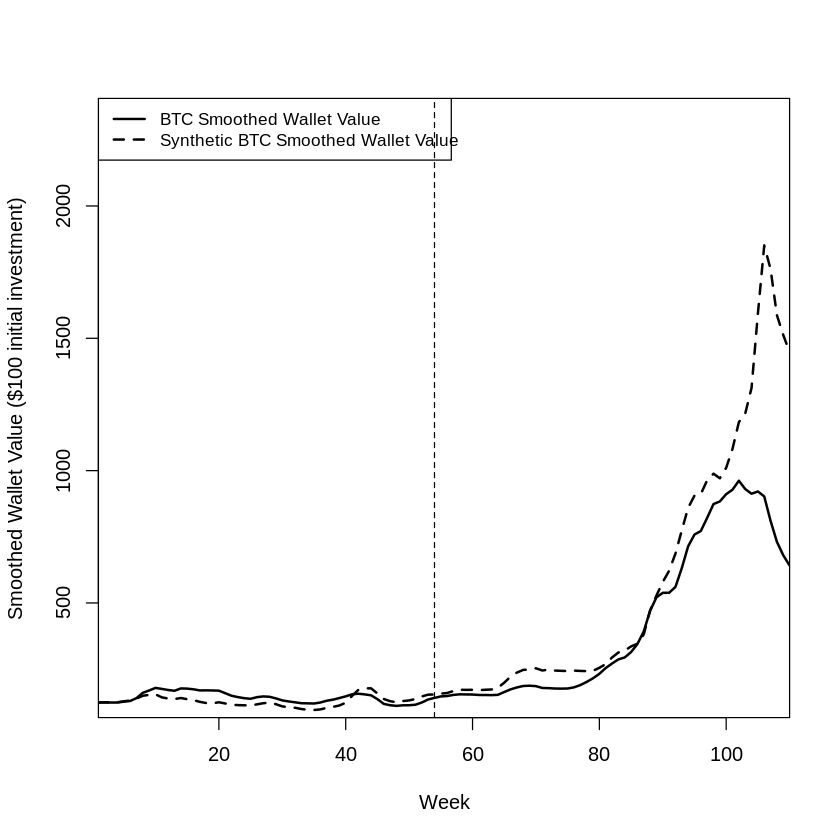

In [ ]:
# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Smoothed Wallet Value", "Synthetic BTC Smoothed Wallet Value"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

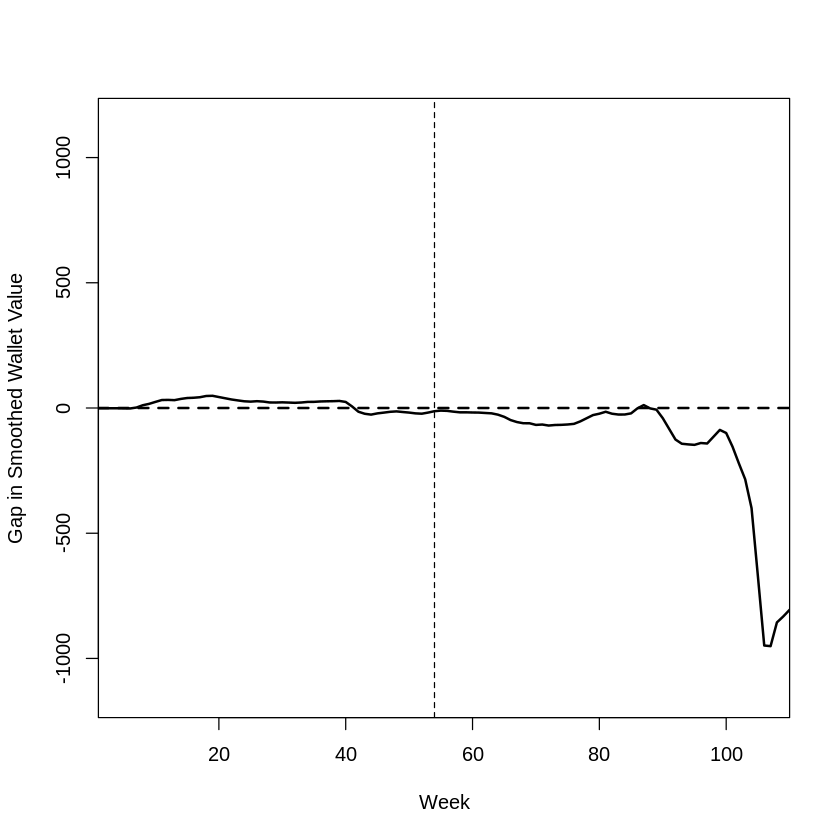

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Smoothed Wallet Value"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

In [ ]:
gaps<- dataprep.out$Y1plot-(
        dataprep.out$Y0plot%*%synth.out$solution.w
        ) ; gaps


,1
1,-0.9970685
2,-0.9970685
3,-0.9970685
4,-0.9970685
5,-1.3372762
6,-1.8769567
7,1.8710593
8,11.0214029
9,16.5845351
10,24.4162786


In [ ]:
mean(gaps[54:110])
max(gaps[54:110])
min(gaps[54:110])

[1] -150.2831

[1] 11.66767

[1] -950.99

## Placebo in-space with Treatment = ETH

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 93.13531 

solution.v:
 0.1160457 0.2288593 0.01554018 0.5439038 0.009327776 0.0287292 0.05759402 

solution.w:
 0.5150216 0.0000000019 0.0000000593 0.0000001461 0.0000000042 0.1128392 0.0000000263 0.0000000156 0.0000000233 0.0000000121 0.0000000148 0.0000000012 0.0000058517 0.0000000675 0.0000000136 0.0000000309 0.0000000292 0.0000000095 0.0000001668 0.3721328 

$tab.pred
                                                        Treated      Synthetic
mean_active_addresses_ratio_Active                        0.011          0.039
mean_new_adoption_rate_New_Adoption_Rate                  0.283          0.314
mean_number_of_transactions_Number_Of_Transactions   695598.024    1011161.255
mean_average_time_between_transactions_Seconds           14.241        320.054
mean_total_addresses_Total              

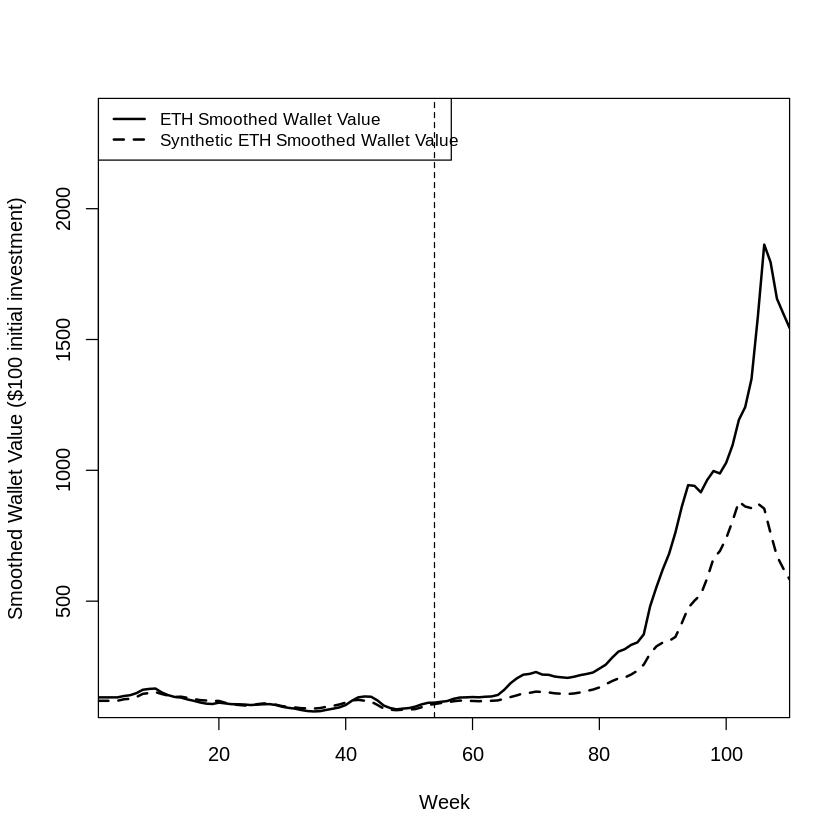

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value_smoothed",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 8,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)


# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("ETH Smoothed Wallet Value", "Synthetic ETH Smoothed Wallet Value"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

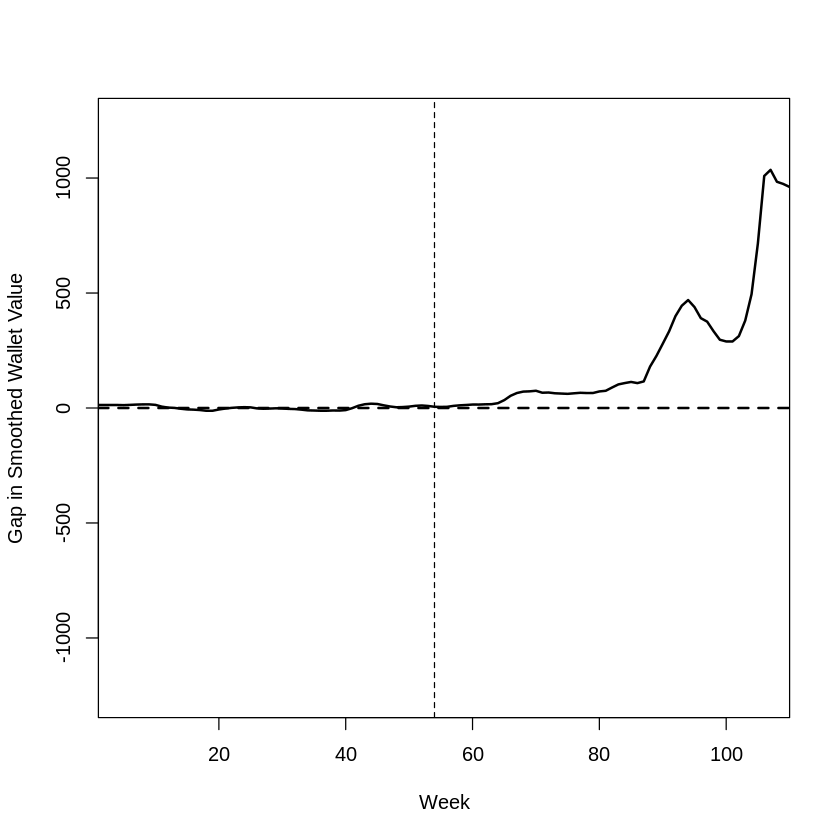

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Smoothed Wallet Value"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

## Spaghetti Plots

In [ ]:
install.packages("SCtools")
library(SCtools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 374.2209 

solution.v:
 0.1274444 0 0.0000000006 0.03012997 0.3321391 0.5047706 0.005515971 

solution.w:
 0.0040256 0.002489282 0.03034447 0.4744498 0.007599352 0.003742104 0.002925822 0.3779925 0.006722172 0.00303923 0.02596951 0.002865812 0.0002684666 0.005233752 0.002561151 0.000005363 0.003411596 0.004401433 0.04195263 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 2303.232 

solution.v:
 0.0000038105 0.002498519 0.2793218 0.002077997 0.1043313 0.4592882 0.1524784 

solution.w:
 0.02014684 0.04234315 0.005073488 0.0162395 0.001641187 0.02616121 0.2263952 0.06725347 0.4505273 0.02319251 0.0147898 0.004041763 0.01884494 0.02914603 0.01433839 0.01718217 0.0

New names:
• `w.weight` -> `w.weight...1`
• `w.weight` -> `w.weight...2`
• `w.weight` -> `w.weight...3`
• `w.weight` -> `w.weight...4`
• `w.weight` -> `w.weight...5`
• `w.weight` -> `w.weight...6`
• `w.weight` -> `w.weight...7`
• `w.weight` -> `w.weight...8`
• `w.weight` -> `w.weight...9`
• `w.weight` -> `w.weight...10`
• `w.weight` -> `w.weight...11`
• `w.weight` -> `w.weight...12`
• `w.weight` -> `w.weight...13`
• `w.weight` -> `w.weight...14`
• `w.weight` -> `w.weight...15`
• `w.weight` -> `w.weight...16`
• `w.weight` -> `w.weight...17`
• `w.weight` -> `w.weight...18`
• `w.weight` -> `w.weight...19`
• `w.weight` -> `w.weight...20`
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


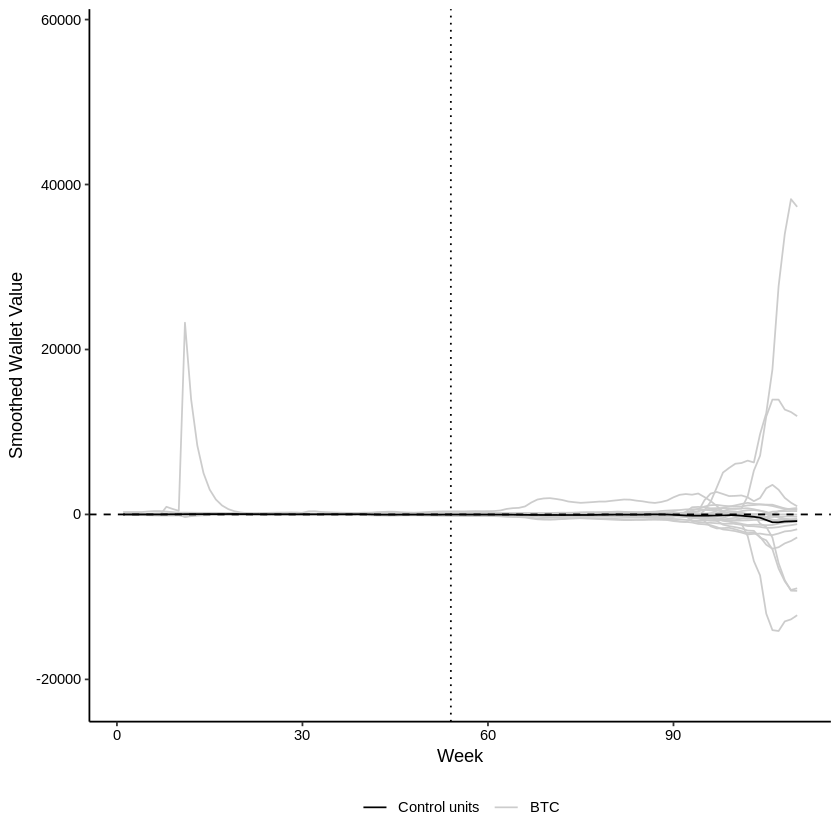

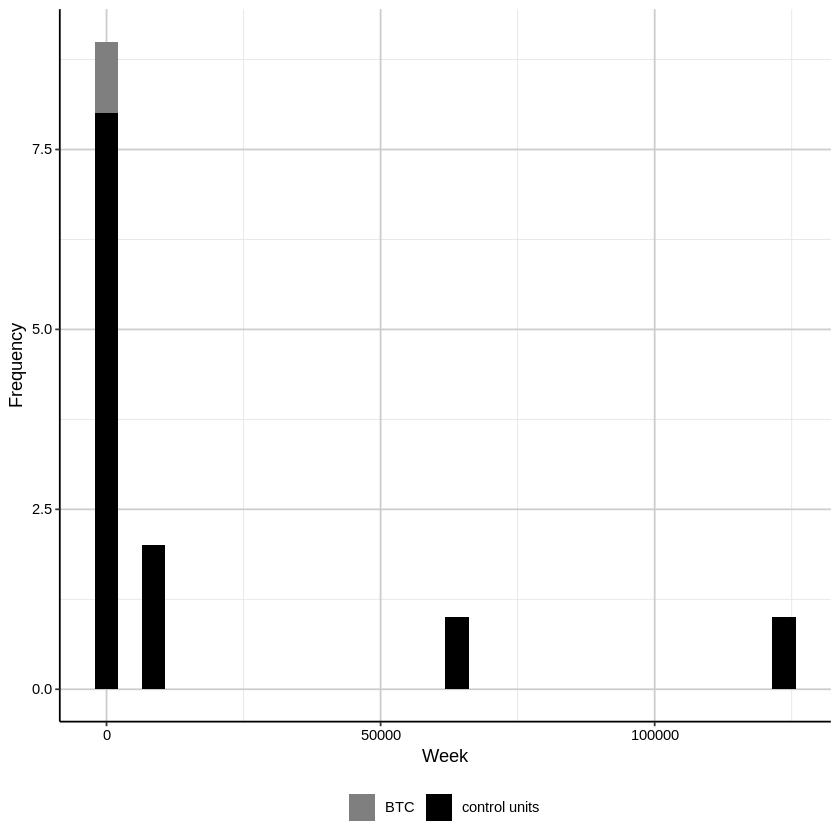

In [ ]:
placebos <- generate.placebos(dataprep.out, synth.out, Sigf.ipop = 3)
plot_placebos(placebos, xlab = "Week", ylab = "Smoothed Wallet Value")
mspe.plot(placebos, discard.extreme = TRUE, mspe.limit = 1, plot.hist = TRUE, xlab = "Week", ylab = "Wallet Value")

In [ ]:
# Summarize wallet_value per cryptocurrency
wallet_value_summary <- df %>%
  group_by(crypto) %>%
  summarize(
    Mean = mean(wallet_value, na.rm = TRUE),
    Median = median(wallet_value, na.rm = TRUE),
    Min = min(wallet_value, na.rm = TRUE),
    Max = max(wallet_value, na.rm = TRUE),
    SD = sd(wallet_value, na.rm = TRUE),
    Count = n()
  )

# Output the summary
print(wallet_value_summary,n=20)

# A tibble: 21 × 7
   crypto   Mean Median    Min    Max     SD Count
   <chr>   <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <int>
 1 ADA     1002.  219.   41.6   4398.  1139.   161
 2 ANKR     549.  125.   15.9   2242.   631.   161
 3 BTC      431.  287.   92.3   1068.   306.   161
 4 CRO      233.  165.   39.7   1116.   219.   161
 5 DOGE    3324.  135.   66.0  21074.  4515.   161
 6 ENJ      597.  135.   40.6   2745.   677.   161
 7 ETH      823.  279.   71.6   2707.   807.   161
 8 FTM     5610.  338.   29.9  33907.  8863.   161
 9 GNO      831.  360.   60.4   3113.   862.   161
10 HOT      452.  313.   25.7   2421.   520.   161
11 IOTX     378.  101.   20.1   2154.   483.   161
12 KCS      612.  134.   64.5   2239.   687.   161
13 LINK    2207. 1938.  100     7502.  1795.   161
14 LPT      151.   65.5   6.49   735.   164.   161
15 MANA    1481.  178.   48.9   9196.  2167.   161
16 MATIC  14969.  642.  100    70259. 19777.   161
17 MKR      271.  130.   45.0   1006.   215.   161
18 NEXO    1

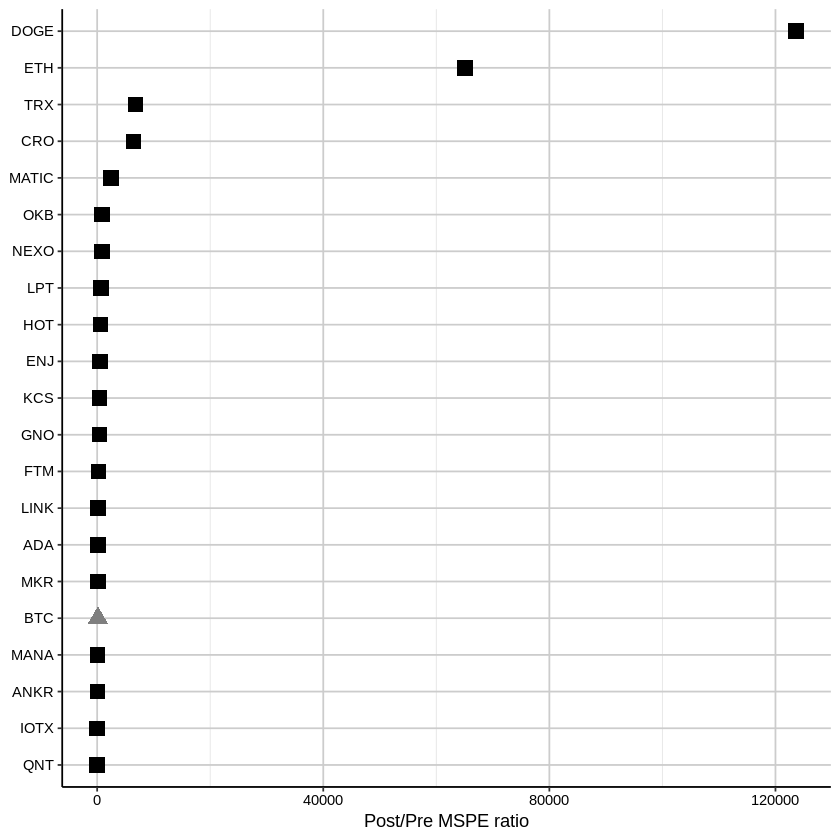

In [ ]:
mspe_plot(placebos)

In [ ]:
# Calculate the p-value
ratio <- mspe.test(placebos)
print(ratio$p.val)
print(ratio$test)

[1] 0.8095238
      MSPE.ratios  unit
1     162.2203172   ADA
2      29.6142489  ANKR
3    6453.5750277   CRO
4  123620.7689212  DOGE
5     470.7325519   ENJ
6   65059.0989702   ETH
7     242.9931369   FTM
8     420.5768311   GNO
9     557.2297386   HOT
10      4.0046783  IOTX
11    432.5344462   KCS
12    166.6136855  LINK
13    688.1905580   LPT
14     39.2094923  MANA
15   2476.0919922 MATIC
16    158.1200856   MKR
17    867.1649617  NEXO
18    875.0041909   OKB
19      0.1300027   QNT
20   6749.1386914   TRX
21    131.0543631   BTC


## Placebo in Time


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 385.8074 

solution.v:
 0.1526684 0.001008559 0.2151496 0.211096 0.02506832 0.3950055 0.0000036788 

solution.w:
 0.0000132717 0.0000192165 0.0000217445 0.005276754 0.0000303937 0.6999563 0.0000460309 0.000013802 0.0000043809 0.0000129621 0.01435935 0.06790897 0.0003434788 0.0000414273 0.0000304089 0.0000360903 0.0000030069 0.2118505 0.0000319901 0 

$tab.pred
                                                         Treated     Synthetic
mean_active_addresses_ratio_Active                         0.029         0.029
mean_new_adoption_rate_New_Adoption_Rate                   0.509         0.305
mean_number_of_transactions_Number_Of_Transactions    326647.523    476494.585
mean_average_time_between_transactions_Seconds           582.962       581.678
mean_total_addresses_Total                         57

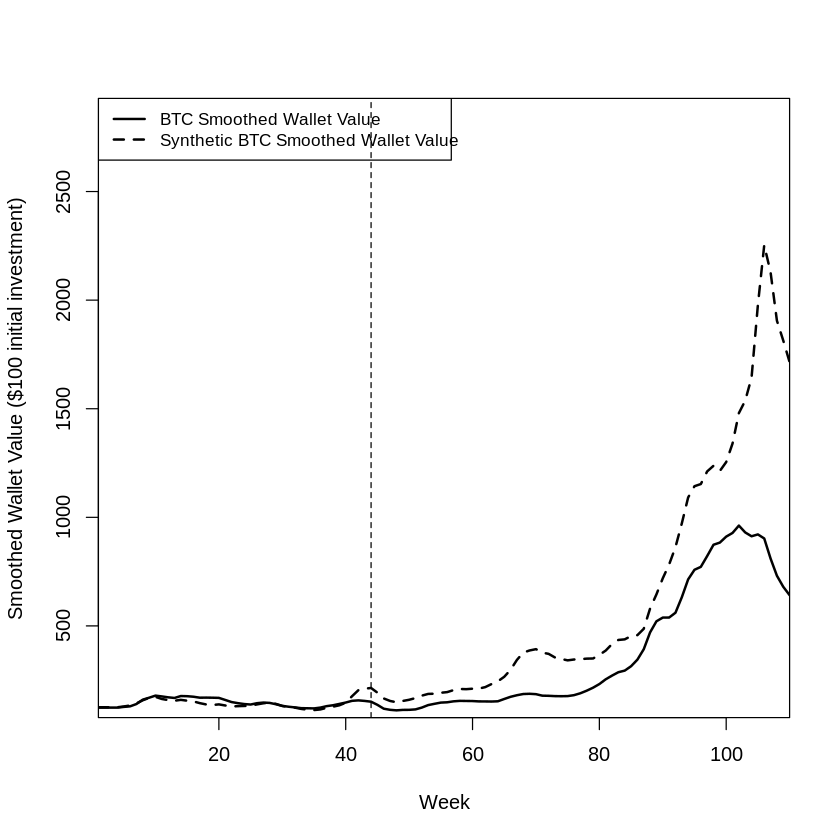

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:44)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value_smoothed",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Smoothed Wallet Value", "Synthetic BTC Smoothed Wallet Value"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 44, lty = 2)

## Different variable placebo


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.00001428543 

solution.v:
 0.8578919 0.02499376 0.08161435 0.01474686 0.02024824 0.0000021707 0.0005027438 

solution.w:
 0.1368402 0.0000015025 0.0000011347 0.3636497 0.0000010703 0.4491829 0.000002305 0.0000037504 0.0000012702 0.03671116 0.0000048958 0.0000021542 0.0000011339 0.0000012708 0.0000224778 0.000001363 0.0000015301 0.01356841 0.0000012678 0.0000005232 

$tab.pred
                                                         Treated      Synthetic
mean_active_addresses_ratio_Active                         0.029          0.027
mean_new_adoption_rate_New_Adoption_Rate                   0.508          0.359
mean_number_of_transactions_Number_Of_Transactions    319695.664     323909.421
mean_average_time_between_transactions_Seconds           589.644         85.772
mean_total_addresses_Total    

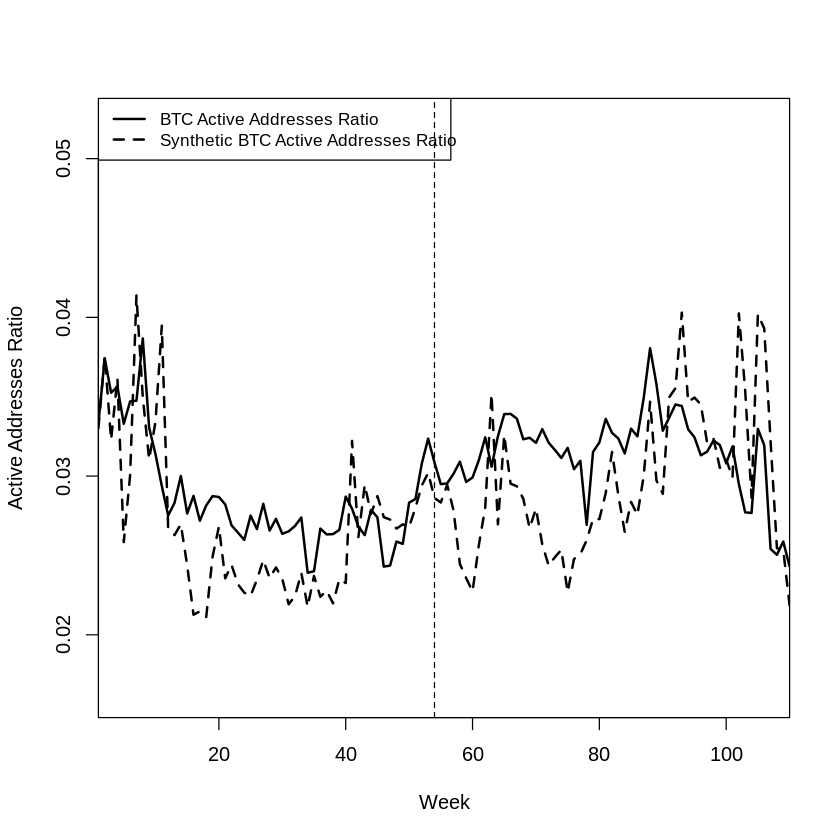

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_active_addresses_ratio_Active",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Active Addresses Ratio",
  Xlab = "Week",
  Legend = c("BTC Active Addresses Ratio", "Synthetic BTC Active Addresses Ratio"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

## Without ETH (still negative)

In [ ]:
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value_smoothed",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 421.7994 

solution.v:
 0.002704945 0.1048675 0.03712429 0.05971857 0.001737075 0.7249285 0.06891904 

solution.w:
 0.1555482 1.5e-08 1.41e-08 2.1e-09 1.23e-08 5.11e-08 4.88e-08 7.2e-09 8.8e-09 9.63e-08 0.2493169 0.595134 1.96e-08 1.118e-07 1.76e-08 5.76e-08 3.889e-07 1.31e-08 6.1e-09 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02 9.000000e-03
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01 3.020000e-01
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05 1.190222e+03
mean_average_time_between_transactions_Seconds     5.896440e+02 5.353010e+02
mean_total_addresses_Total                         5.897094e+08 1.961113e+06
mean_balance_by_time_held_undefined_Traders___1M_  

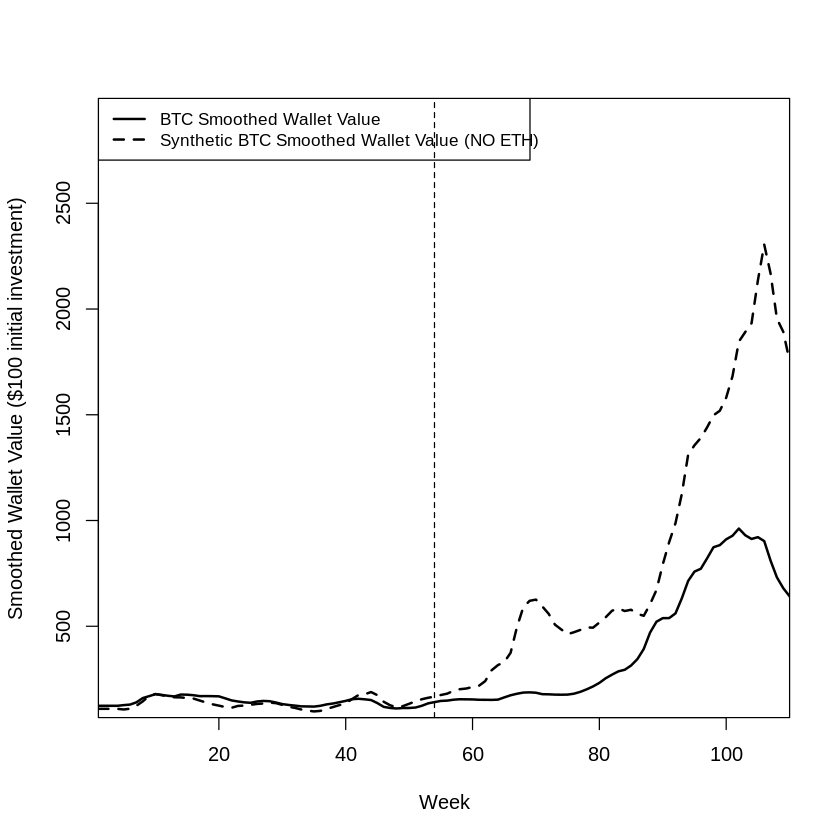

In [ ]:
# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Smoothed Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Smoothed Wallet Value", "Synthetic BTC Smoothed Wallet Value (NO ETH)"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

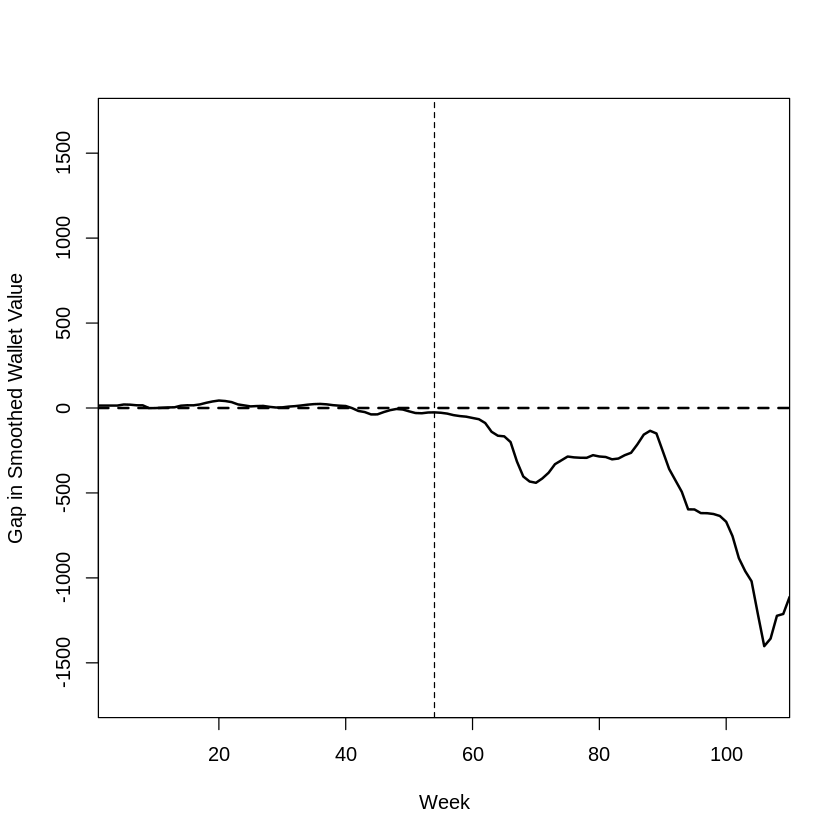

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Smoothed Wallet Value"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

# Wallet Log + Smoothed

In [ ]:
df <- read.csv("/content/sample_data/recoded_price_with_log.csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_new_adoption_rate_New_Adoption_Rate,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,0.49666443,2624.1429,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,0.32048357,168.2857,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,0.52001900,351674.4286,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517
4,CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,0.06726671,242.8571,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,0.29178829,28229.7143,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,0.21136729,812.7143,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517


In [ ]:
# Define the window size for initial simple moving average and EMA
window_size <- 4  # Number of periods for initial simple average and EMA

# Smooth the log_wallet_value data
df <- df %>%
  group_by(cryptono) %>%
  arrange(week_index) %>%
  mutate(
    # For the first 4 weeks, use a simple moving average of log_wallet_value
    initial_smooth_log = ifelse(row_number() <= window_size,
                                mean(log_wallet_value[1:window_size], na.rm = TRUE),
                                NA_real_),

    # For the remaining weeks, apply EMA with a window size of 4 to log_wallet_value
    log_wallet_value_smoothed = ifelse(row_number() > window_size,
                                       EMA(log_wallet_value, n = window_size),
                                       initial_smooth_log)
  ) %>%
  ungroup()

# Check the structure of the smoothed data (optional)
head(df)

# Save the smoothed data to a new CSV file
write.csv(df, "/content/sample_data/recoded_and_smoothed_log_wallet_value.csv", row.names = FALSE)

crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,log_wallet_value,initial_smooth_log,log_wallet_value_smoothed
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ADA,2,2019-05-05,2019-05-08,0.022624748,6.516071e-02,67019.4286,28969.5714,74398.7143,82846.857,⋯,1686788.43,315903.857,1370885,6.516071e-02,1.534667e+03,100,1,4.60517,4.791300,4.791300
ANKR,4,2019-05-05,2019-05-08,0.022720640,7.666929e-03,225.4286,104.4286,250.8571,1478.143,⋯,10188.43,3281.429,6907,7.666929e-03,1.304303e+04,100,1,4.60517,4.573934,4.573934
BTC,1,2019-05-05,2019-05-07,0.033321550,6.078957e+03,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,517412351.10,23911250.430,493501101,6.078957e+03,1.645019e-02,100,1,4.60517,4.811893,4.811893
CRO,5,2019-05-05,2019-05-08,0.008813143,6.951500e-02,837.8571,2526.4286,11398.5714,6907.143,⋯,24940.14,23634.143,1306,6.951500e-02,1.438538e+03,100,1,4.60517,4.585009,4.585009
DOGE,6,2019-05-05,2019-05-08,0.033563768,2.578643e-03,1929431.5710,360614.2857,221700.4286,73778.571,⋯,40338928.29,2314227.429,38024701,2.578643e-03,3.878009e+04,100,1,4.60517,4.734364,4.734364
ENJ,7,2019-05-05,2019-05-08,0.018651992,1.411429e-01,2981.1429,2364.0000,8503.0000,8486.857,⋯,93068.00,26437.000,66631,1.411429e-01,7.085020e+02,100,1,4.60517,4.689696,4.689696


In [ ]:
df <- read.csv("/content/sample_data/recoded_and_smoothed_log_wallet_value.csv")
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "log_wallet_value_smoothed",  # Use the log of the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.03863804 

solution.v:
 0.1856266 0.01003182 0.2765703 0.107474 0.01971497 0.349107 0.0514754 

solution.w:
 0.0008531343 7.979e-07 1.1603e-06 0.002462305 1.886e-06 0.7897078 3.3543e-06 0 4.5894e-06 0.0003057829 2.27e-08 2.06172e-05 4.91217e-05 2.5717e-06 3.96244e-05 3.5695e-06 5.0285e-06 0.2065377 9.731e-07 0 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02        0.024
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01        0.297
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05   549438.760
mean_average_time_between_transactions_Seconds     5.896440e+02      559.406
mean_total_addresses_Total                         5.897094e+08 78383363.430
mean_balance_by_time_he

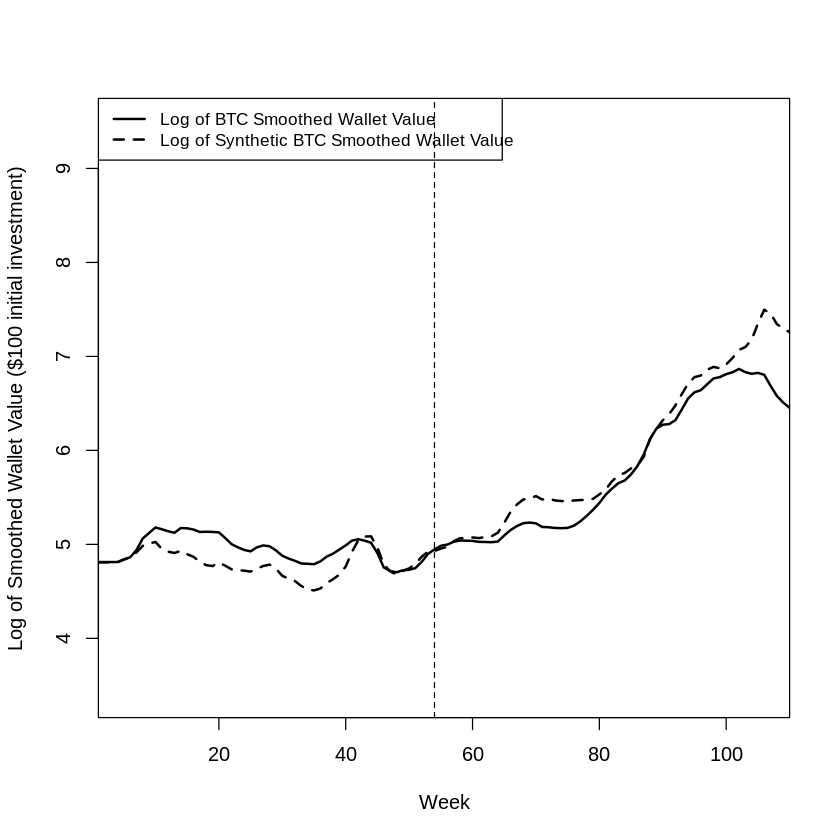

In [ ]:
# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Log of Smoothed Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("Log of BTC Smoothed Wallet Value", "Log of Synthetic BTC Smoothed Wallet Value"),
  Legend.position = "topleft"
)

# Add a vertical line for the intervention
abline(v = 54, lty = 2)

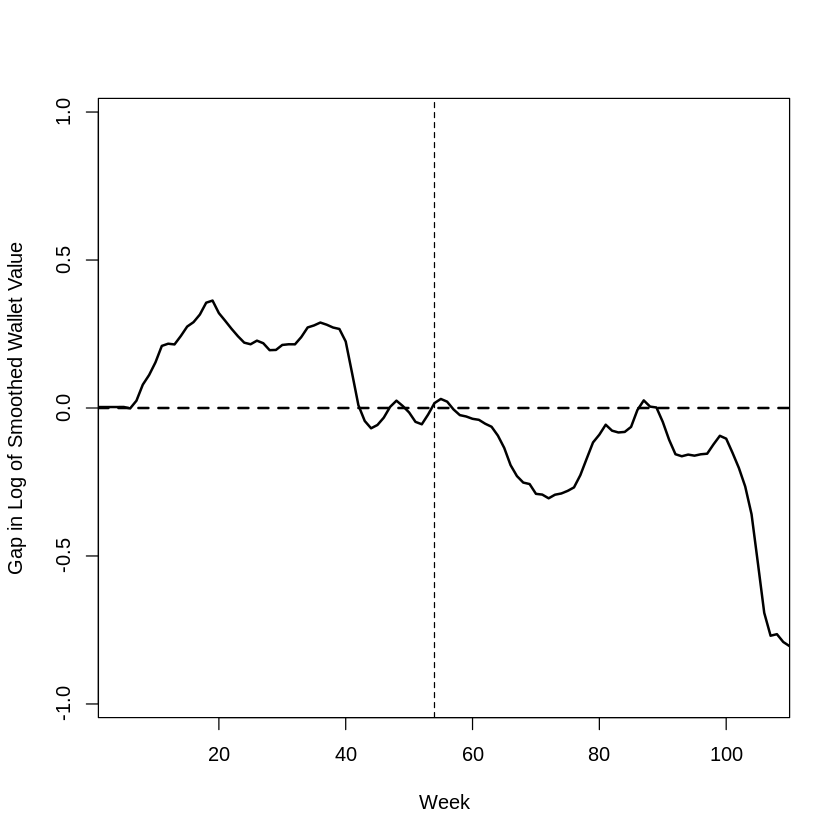

In [ ]:
# Main model: gaps plot to show the difference over time
gaps.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = c("Gap in Log of Smoothed Wallet Value"),
  Xlab = c("Week"),
  Main = ""
)

# Add a vertical line for the intervention in the gaps plot
abline(v = 54, lty = 2)

# Smoothed Wallet Value with ETH weight 1

In [ ]:
df <- read.csv("/content/sample_data/recoded_and_smoothed_wallet_value.csv")
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# List of predictors
predictors_list <- c(
 "mean_active_addresses_ratio_Active",
 "mean_new_adoption_rate_New_Adoption_Rate",
 "mean_number_of_transactions_Number_Of_Transactions",
 "mean_average_time_between_transactions_Seconds",
 "mean_total_addresses_Total",
 "mean_balance_by_time_held_undefined_Traders___1M_",
 "mean_addresses_by_holdings_in_usd_X_1_00____10_00"
)

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:110)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value_smoothed",  # Use the smoothed wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

In [ ]:
# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 662.1259 

solution.v:
 0.07245732 0.01558643 0.2645217 0.419505 0.002545975 0.1440874 0.08129623 

solution.w:
 0.0001402104 2.215e-07 3.426e-07 1.72528e-05 4.577e-07 0.795251 1.2492e-06 0 1.7732e-06 2e-07 0 3.6726e-06 2.6262e-05 7.273e-07 4.0243e-06 8.119e-07 1.6435e-06 0.2045499 2.485e-07 0 

$tab.pred
                                                        Treated    Synthetic
mean_active_addresses_ratio_Active                 2.900000e-02        0.024
mean_new_adoption_rate_New_Adoption_Rate           5.080000e-01        0.296
mean_number_of_transactions_Number_Of_Transactions 3.196957e+05   553217.578
mean_average_time_between_transactions_Seconds     5.896440e+02      553.852
mean_total_addresses_Total                         5.897094e+08 78821688.072
mean_balance_by_time_held_undefined_Trader

In [ ]:
dataprep.out$Y0plot%*%c(0, 0, 0, 0, 0,1,0,0,0,0, 0, 0, 0, 0, 0,0,0,0,0,0, 0,0,0,0,0,0)

ERROR: Error in dataprep.out$Y0plot %*% c(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, : non-conformable arguments


# Show growth and growth rates

In [ ]:
library(ggplot2)

In [ ]:
df <- read.csv("/content/sample_data/recoded_and_smoothed_wallet_value.csv")
head(df)

,crypto,cryptono,week,mean_DateTime,mean_active_addresses_ratio_Active,mean_active_addresses_ratio_Price,mean_addresses_by_holdings_in_usd_X_0_00____1_00,mean_addresses_by_holdings_in_usd_X_1_00____10_00,mean_addresses_by_holdings_in_usd_X_10_00____100_00,mean_addresses_by_holdings_in_usd_X_100_00____1k,⋯,mean_number_of_transactions_Number_Of_Transactions,mean_total_addresses_Total,mean_total_addresses_Total_With_Balance,mean_total_addresses_Total_Zero_Balance,baseline_price,initial_quantity,wallet_value,week_index,wallet_value_smoothed,initial_smooth
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,ADA,2,2019-05-05,2019-05-08,0.022624748,0.065160714,67019.4286,28969.5714,74398.7143,82846.857,⋯,2624.1429,1686788.43,315903.857,1370885,0.065160714,1534.66703196,100,1,121.18827,121.18827
2,ANKR,4,2019-05-05,2019-05-08,0.022720640,0.007666929,225.4286,104.4286,250.8571,1478.143,⋯,168.2857,10188.43,3281.429,6907,0.007666929,13043.03269216,100,1,97.09956,97.09956
3,BTC,1,2019-05-05,2019-05-07,0.033321550,6078.957143000,7598899.4290,5603131.1430,5992359.1430,3534753.714,⋯,351674.4286,517412351.10,23911250.430,493501101,6078.957143000,0.01645019,100,1,123.91840,123.91840
4,CRO,5,2019-05-05,2019-05-08,0.008813143,0.069515000,837.8571,2526.4286,11398.5714,6907.143,⋯,242.8571,24940.14,23634.143,1306,0.069515000,1438.53844494,100,1,98.02047,98.02047
5,DOGE,6,2019-05-05,2019-05-08,0.033563768,0.002578643,1929431.5710,360614.2857,221700.4286,73778.571,⋯,28229.7143,40338928.29,2314227.429,38024701,0.002578643,38780.08919635,100,1,114.16858,114.16858
6,ENJ,7,2019-05-05,2019-05-08,0.018651992,0.141142857,2981.1429,2364.0000,8503.0000,8486.857,⋯,812.7143,93068.00,26437.000,66631,0.141142857,708.50202451,100,1,109.03467,109.03467


In [ ]:
# Filter for selected cryptocurrencies: ETH, OKB, LPT, LINK, ADA, TRX, BTC
selected_cryptos <- c("ETH", "OKB", "LPT", "LINK", "ADA", "TRX", "BTC")
df_filtered <- df %>%
  filter(crypto %in% selected_cryptos)

# Calculate weekly growth rate as percentage change for wallet_value
df_growth <- df_filtered %>%
  group_by(crypto) %>%
  arrange(week_index) %>%
  mutate(
    growth_rate = (wallet_value / lag(wallet_value) - 1) * 100  # Calculate % change
  ) %>%
  ungroup()

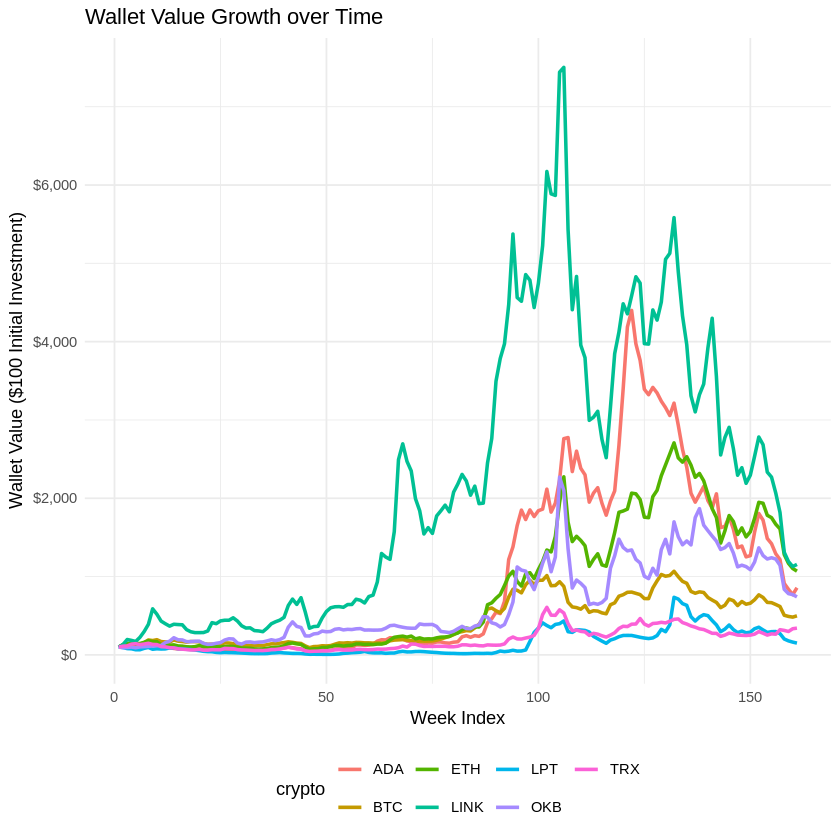

In [ ]:
# Plot wallet value over time for each cryptocurrency
ggplot(df_filtered, aes(x = week_index, y = wallet_value, color = crypto)) +
  geom_line(size = 1) +
  labs(
    title = "Wallet Value Growth over Time",
    x = "Week Index",
    y = "Wallet Value ($100 Initial Investment)"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom") +
  scale_y_continuous(labels = scales::dollar)

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_line()`).”


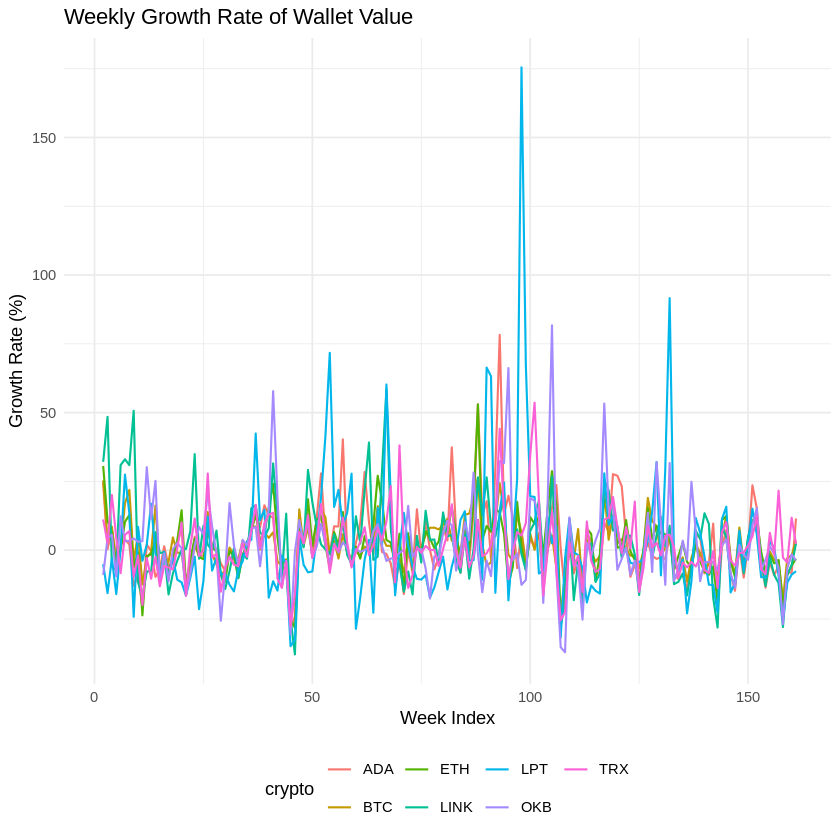

In [ ]:
# Plot growth rates over time for each cryptocurrency
ggplot(df_growth, aes(x = week_index, y = growth_rate, color = crypto)) +
  geom_line(size = 0.6) +
  labs(
    title = "Weekly Growth Rate of Wallet Value",
    x = "Week Index",
    y = "Growth Rate (%)"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

# BTC vs Average Price of Others

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


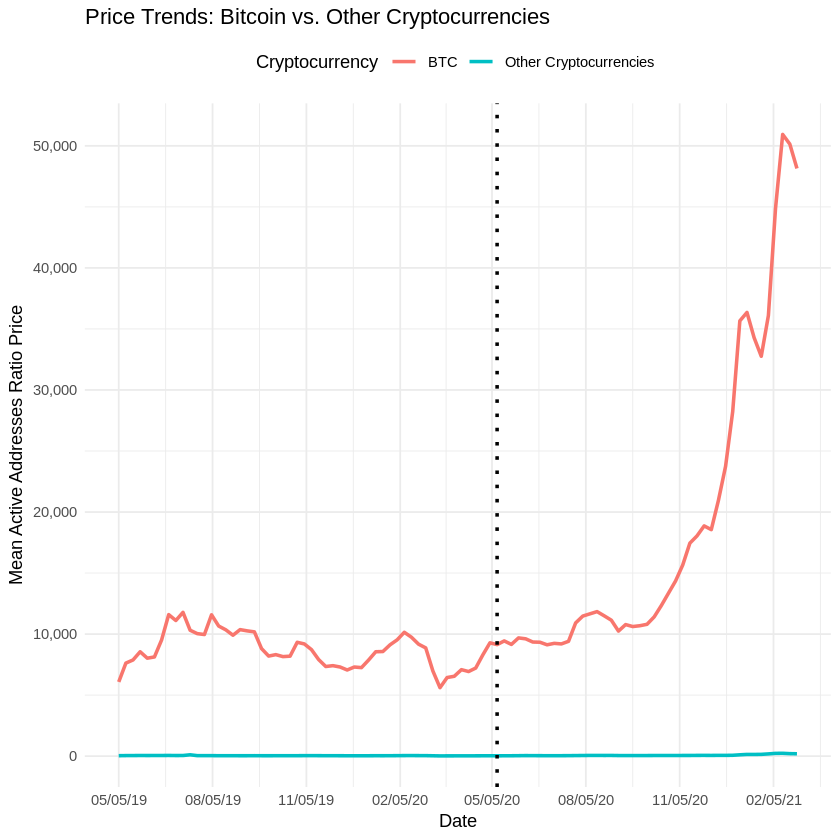

In [ ]:
# Load necessary libraries
library(scales)
library(ggplot2)

#2019-05-05: 1 (min)
#2020-05-10: 54 (halving)
#2020-11-22: 82 (half a year after treatment)
#
#2022-05-29: 161 (max)

# Load the dataset
df <- read.csv("/content/sample_data/recoded_price.csv")

# Define key dates and week ranges
start_date <- as.Date("2019-05-05")  # Corresponding to week_index = 1
halving_date <- as.Date("2020-05-10")  # Corresponding to week_index = 56
end_date <- as.Date("2021-02-28")  # Corresponding to week_index = 95

# Add a date column based on week_index
df <- df %>%
  mutate(date = start_date + (week_index - 1) * 7)  # Convert weeks to dates

# Define the time periods
time_plot <- seq(start_date, end_date, by = "week")

# Filter the data to include only the weeks in the time_plot range
df_filtered <- df %>%
  filter(date %in% time_plot)

# Extract BTC data
btc_data <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(date, mean_active_addresses_ratio_Price)

# Compute the average mean_active_addresses_ratio_Price for other cryptocurrencies
other_crypto_avg <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(date) %>%
  summarize(mean_price = mean(mean_active_addresses_ratio_Price, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data <- btc_data %>%
  mutate(group = "BTC")

other_plot_data <- other_crypto_avg %>%
  rename(mean_active_addresses_ratio_Price = mean_price) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data <- bind_rows(btc_plot_data, other_plot_data)

# Create the plot
ggplot(plot_data, aes(x = date, y = mean_active_addresses_ratio_Price, color = group)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(halving_date), linetype = "dotted", color = "black", size = 1) +
  labs(
    title = "Price Trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Date",
    y = "Mean Active Addresses Ratio Price",
    color = "Cryptocurrency"
  ) +
  scale_x_date(date_labels = "%m/%d/%y", breaks = seq(start_date, end_date, by = "3 months")) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

[1] "Other cryptocurrencies:"
   crypto
1     ADA
2    ANKR
3     CRO
4    DOGE
5     ENJ
6     ETH
7     FTM
8     GNO
9     HOT
10   IOTX
11    KCS
12   LINK
13    LPT
14   MANA
15  MATIC
16    MKR
17   NEXO
18    OKB
19    QNT
20    TRX


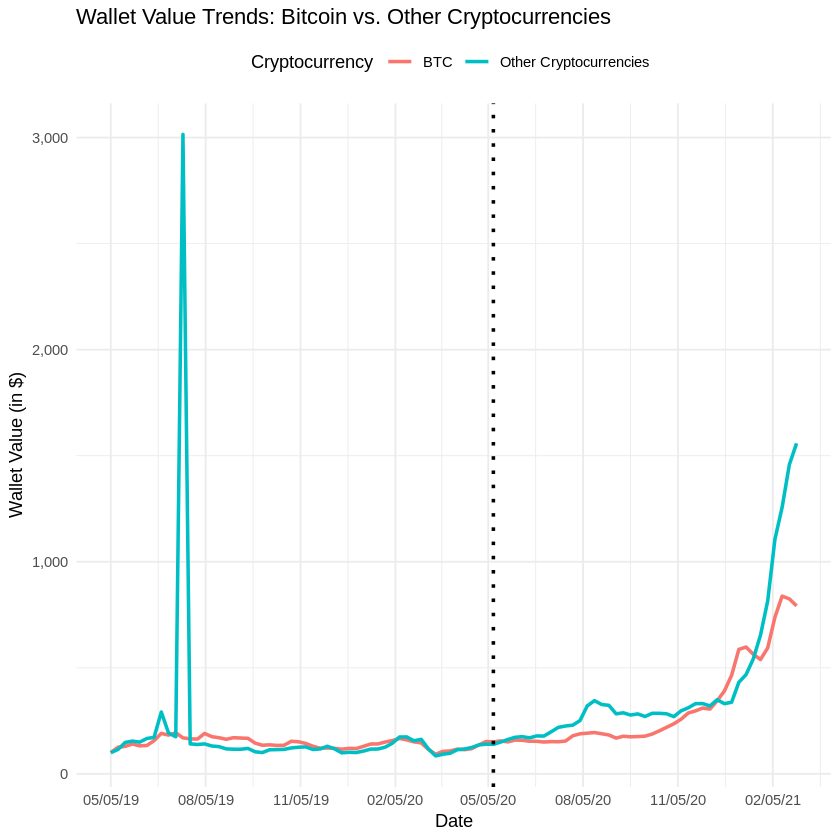

In [ ]:
# Add a date column based on week_index
df_filtered <- df_filtered %>%
  mutate(date = start_date + (week_index - 1) * 7)  # Convert week_index to dates

# Extract BTC wallet value data
btc_data_wallet_value <- df_filtered %>%
  filter(crypto == "BTC") %>%
  select(date, wallet_value)

# Compute the average wallet_value for other cryptocurrencies
other_crypto_avg_wallet_value <- df_filtered %>%
  filter(crypto != "BTC") %>%
  group_by(date) %>%
  summarize(mean_wallet_value = mean(wallet_value, na.rm = TRUE))

# Prepare data for plotting
btc_plot_data_wallet_value <- btc_data_wallet_value %>%
  mutate(group = "BTC")

other_plot_data_wallet_value <- other_crypto_avg_wallet_value %>%
  rename(wallet_value = mean_wallet_value) %>%
  mutate(group = "Other Cryptocurrencies")

# Combine the BTC and other cryptocurrencies data
plot_data_wallet_value <- bind_rows(btc_plot_data_wallet_value, other_plot_data_wallet_value)

# Create the plot
ggplot(plot_data_wallet_value, aes(x = date, y = wallet_value, color = group)) +
  geom_line(size = 1) +
  geom_vline(xintercept = as.numeric(halving_date), linetype = "dotted", color = "black", size = 1) +
  labs(
    title = "Wallet Value Trends: Bitcoin vs. Other Cryptocurrencies",
    x = "Date",
    y = "Wallet Value (in $)",
    color = "Cryptocurrency"
  ) +
  scale_x_date(date_labels = "%m/%d/%y", breaks = seq(start_date, end_date, by = "3 months")) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  theme(legend.position = "top")

# Filter and get the unique cryptocurrencies excluding BTC
other_cryptos <- df %>%
  filter(crypto != "BTC") %>%
  distinct(crypto) %>%
  arrange(crypto)

# Output the list of other cryptocurrencies
print("Other cryptocurrencies:")
print(other_cryptos)

# Predictor Transformations

[1] "mean_active_addresses_ratio_Active"                
[2] "mean_new_adoption_rate_New_Adoption_Rate"          
[3] "mean_number_of_transactions_Number_Of_Transactions"
[4] "mean_average_time_between_transactions_Seconds"    
[5] "mean_total_addresses_Total"                        
[6] "mean_balance_by_time_held_undefined_Traders___1M_"
[7] "cryptono"                                          
[8] "mean_addresses_by_holdings_in_usd_X_0_00____1_00"  
[9] "mean_addresses_by_holdings_in_usd_X_1_00____10_00"

In [ ]:
# Define the columns representing the holdings brackets
holdings_columns <- c(
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00",
  "mean_addresses_by_holdings_in_usd_X_100_00____1k",
  "mean_addresses_by_holdings_in_usd_X_1k____10k",
  "mean_addresses_by_holdings_in_usd_X_10k____100k"
)

# Add "_share" columns for each bracket
df <- df %>%
  rowwise() %>%
  mutate(
    total_holdings = sum(c_across(all_of(holdings_columns)), na.rm = TRUE),
    across(
      all_of(holdings_columns),
      .fns = ~ 100 * .x / total_holdings,
      .names = "{.col}_share"
    )
  ) %>%
  ungroup()

# Add the new normalized variables
df <- df %>%
  mutate(
    # transactions_by_addresses
    transactions_by_addresses = mean_number_of_transactions_Number_Of_Transactions / mean_total_addresses_Total,

    # time_between_transactions_by_addresses
    time_between_transactions_by_addresses = mean_average_time_between_transactions_Seconds / mean_total_addresses_Total,

    # Calculate the share of zero balance addresses out of total addresses
    mean_total_addresses_Total_Zero_Balance_share = mean_total_addresses_Total_Zero_Balance / mean_total_addresses_Total,

    # Calculate the share of addresses with balance out of total addresses
    mean_total_addresses_Total_With_Balance_share = mean_total_addresses_Total_With_Balance / mean_total_addresses_Total,

    # Calculate new to active addresses share
    new_to_active_addresses_share = mean_daily_active_addresses_New_Addresses / mean_daily_active_addresses_Active_Addresses


  )
# Normalize the remaining variables with large values
df <- df %>%
  mutate(
    # Log normalize number of transactions
    log_number_of_transactions = log1p(mean_number_of_transactions_Number_Of_Transactions),

    # Scale total addresses between 0 and 1
    total_addresses_normalized = mean_total_addresses_Total / max(mean_total_addresses_Total, na.rm = TRUE),

    # Normalize trader balance relative to the sum of all categories
    trader_balance_normalized = mean_balance_by_time_held_undefined_Traders___1M_ /
      max(mean_balance_by_time_held_undefined_Traders___1M_, na.rm = TRUE)
  )

In [ ]:
# If needed, saving again after transformations
write.csv(df, "/content/sample_data/2020_recoded_smoothed.csv (1)", row.names = FALSE)

 [1] "mean_active_addresses_ratio_Active"                       
 [2] "cryptono"                                                 
 [3] "mean_active_addresses_ratio_Price"                        
 [4] "mean_addresses_by_holdings_in_usd_X_0_00____1_00"         
 [5] "mean_average_time_between_transactions_Seconds"           
 [6] "mean_balance_by_time_held_undefined_Traders___1M_"        
 [7] "mean_new_adoption_rate_New_Adoption_Rate"                 
 [8] "mean_number_of_transactions_Number_Of_Transactions"       
 [9] "wallet_value"                                             
[10] "week_index"                                               
[11] "mean_addresses_by_holdings_in_usd_X_0_00____1_00_share"   
[12] "mean_addresses_by_holdings_in_usd_X_1_00____10_00_share"  
[13] "mean_addresses_by_holdings_in_usd_X_10_00____100_00_share"
[14] "mean_addresses_by_holdings_in_usd_X_10k____100k_share"    
[15] "time_between_transactions_by_addresses"                   
[16] "mean_total_addresse

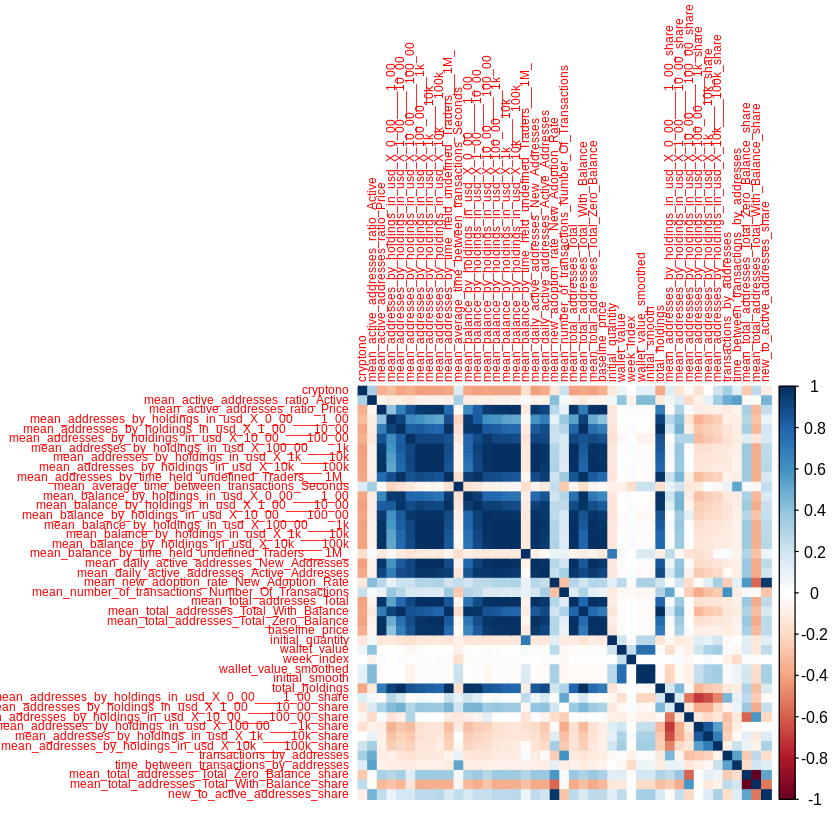

In [ ]:
# Calculate correlation matrix for all numeric predictors in the dataset
# Exclude non-numeric columns to get correlations only between numeric predictors
numeric_df <- df %>% select(where(is.numeric))
cor_matrix <- cor(numeric_df, use = "complete.obs")

# Visualize the correlation matrix to see how predictors correlate
corrplot(cor_matrix, method = "color", tl.cex = 0.6)


# Set the initial predictors list
predictors_list <- c(
  "mean_active_addresses_ratio_Active"
)

# Define a threshold for low correlation (adjust as necessary)
cor_threshold <- 0.6

# Function to add predictors with low correlation to existing predictors_list
add_predictors <- function(cor_matrix, predictors_list, cor_threshold) {
  for (col in colnames(cor_matrix)) {
    if (col %in% predictors_list) next  # Skip if already in predictors_list

    # Calculate maximum absolute correlation of this column with predictors in predictors_list
    max_cor <- max(abs(cor_matrix[col, predictors_list]), na.rm = TRUE)

    # Add to predictors_list if maximum correlation is below threshold
    if (max_cor < cor_threshold) {
      predictors_list <- c(predictors_list, col)
    }
  }
  return(predictors_list)
}

# Apply the function to extend the predictors_list
predictors_list <- add_predictors(cor_matrix, predictors_list, cor_threshold)

# Check the extended predictors_list
print(predictors_list)

In [ ]:
df <- read.csv("/content/sample_data/2020_recoded_smoothed.csv (1)")

In [ ]:
# New list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_number_of_transactions_Number_Of_Transactions",
  "mean_average_time_between_transactions_Seconds",
  "mean_total_addresses_Total",
  "mean_balance_by_time_held_undefined_Traders___1M_",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00_share",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00_share",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00_share",
  "mean_addresses_by_holdings_in_usd_X_10k____100k_share",
  "time_between_transactions_by_addresses",
  "mean_total_addresses_Total_Zero_Balance_share"
)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 347.7668 

solution.v:
 0.0002203173 0.1213437 0.0008378111 0.4785406 0.00346074 0.1748055 0.000018665 0.0000353912 0.0000125946 0.04617827 0.08986333 0.08468308 

solution.w:
 0.5467639 0.0000000072 0.000000003 0 0.0000000926 0.1677085 0.0000000055 0.0000000008 0.0000000039 0.1438377 0.1416808 0.000000003 0.0000087345 0.0000000615 0.0000000241 0.0000001857 0.0000000002 0.000000003 0.0000000017 

$tab.pred
                                                                Treated
mean_active_addresses_ratio_Active                                0.029
mean_new_adoption_rate_New_Adoption_Rate                          0.508
mean_number_of_transactions_Number_Of_Transactions           319695.664
mean_average_time_between_transactions_Seconds                  589.644
mean_total_addresses_Total               

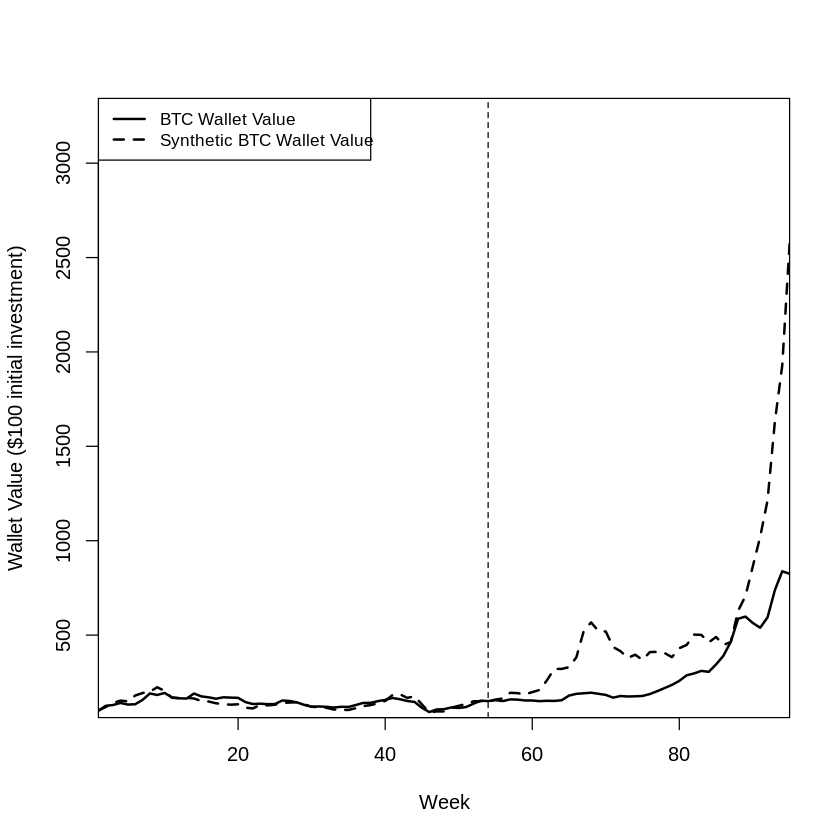

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO, ETH
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:95)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier here
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)



### Convert to Date